In [310]:
import pandas as pd
import json
import requests
import warnings
from matplotlib import pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
from IPython.display import IFrame
import re
import numpy as np
from cycler import cycler
import squarify
import time
from selenium import webdriver
from sqlalchemy import create_engine

font = {'family' : 'helvetica',
        'size'   : 24}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Cuomo Campaign Contributions from Board of Elections

- Board of Elections (BOE) releases data in January and July. The July data came out 07/17/2018
- First I put the CSVs into Pandas to be able to work with the data in Python.
- then I take the dollar signs out of the 'Amount' column, ...and convert it to float so I can do calculations.
- I convert the 'Date' column to Pandas datetime, so I can sort and filter by date.

In [311]:
#This is the July 2018 BOE data
df1 = pd.read_csv("tabula-schedA.csv")
df2 = pd.read_csv("tabula-schedB.csv")
df3 = pd.read_csv("tabula-schedC.csv")
df4 = pd.read_csv("tabula-schedD.csv")

cols = {"NAME":"Donor",
        "ADDRESS":"Address",
        "DATE":"Date",
        "AMOUNT":"Amount"}

df1.rename(columns={"NAME":"Donor","ADDRESS":"Address","DATE":"Date","AMOUNT":"Amount",
"CITY":"City", "STATE": "State"},inplace=True)
df1['Address']=df1['Address'].str.strip()+' '+df1['City'].str.strip()
df1 = df1[['Date','Donor','Address','Amount']]

df_list = [df2, df3, df4]
for frame in df_list:
    frame.rename(columns=cols,inplace=True)
    frame['Address']=frame['Address'].str.strip()+' '+frame['Unnamed: 4'].str.strip()
    frame = frame[['Date','Donor','Address','Amount']]
    jul_df=pd.concat([df1, frame],ignore_index=True)

jul_df['Date']=pd.to_datetime(jul_df['Date'], format='%m/%d/%y')

In [312]:
#This is the BOE data from all previous years
df = pd.read_csv("Campaign_Contributions.csv")
df = df[['Donor','Address', 'Check No.', 'Amount', 'Date','Recipient','Transaction Code', 'Contribution Code', 'Fiscal Report']]

df = df.append(jul_df, ignore_index=True)

df['Amount'] = df['Amount'].replace( '[\$,)]','', regex=True ).astype(float)
df['Donor'] = df['Donor'].str.strip()

# Now we have all of the donor data from Cuomo-- from attorney general to governor, up to July 16, 2018.
- There is a sum total of $140,087,063.46: just names, check numbers, dates, and addresses.
- But who are they? What is the big picture?
- What industries and groups own Cuomo?

In [313]:
#Starting point
df['Amount'].sum()

140087063.46

## I used Follow the Money, which has done extensive research on campaign donors, because I think that Cuomo's donors have many repeats over the years.

- Their data is not quite up to date, but that's okay. I just want the historical donor information; I'll merge with the current data, and since names don't change (or shouldn't) over the years, it will help me attribute more of Cuomo's donors to industry groups and parent organizations.

In [314]:
ftm_df = pd.read_csv("FollowTheMoneyDownload20180705(010706).csv")
#I'm actually just interested in unique donors over the years: throw out the repeats!
ftm_df = ftm_df.drop_duplicates('Original_Name', keep='first')
ftm_df['Original_Name'] = ftm_df['Original_Name'].str.strip() 
df = pd.merge(df, ftm_df, left_on='Donor', right_on='Original_Name', how='left', suffixes=['_boe','_ftm'])
df.head()

,Address,Amount_boe,Check No.,Contribution Code,Date_boe,Donor,Fiscal Report,Recipient,Transaction Code,request,...,State,Zip:token,Zip:id,Zip,In-State:token,In-State:id,In-State,Parent_Org_or_Employer:token,Parent_Org_or_Employer:id,Parent_Org_or_Employer
0,"1 PALLISAR ROAD IRVINGTON, NY, 10533",416367.0,TR51007,NaN,05/10/2007,"ANDREW CUOMO FOR ATTORNEY GENERAL, INC.",Periodic July,ANDREW CUOMO 2018 INC.,Transfers In,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"PO BOX 122 BUFFALO, NY, 14201",256735.0,NaN,NaN,10/02/2014,FRIENDS FOR KATHY HOCHUL,32 Day Pre General,ANDREW CUOMO 2018 INC.,Other Receipts,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"PO BOX 122 BUFFALO, NY, 14201",217138.0,NaN,NaN,09/12/2014,FRIENDS FOR KATHY HOCHUL,10 Day Post Primary,ANDREW CUOMO 2018 INC.,Other Receipts,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"1633 BROADWAY NEW YORK, NY, 10019",100000.0,108896,Partnership,05/28/2013,"KASOWITZ, BENSON, TORRES & FRIEDMAN LLP",Periodic July,ANDREW CUOMO 2018 INC.,Monetary Contributions/Individual and Partnerships,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"50 SUTTON PLACE SOUTH NEW YORK, NY, 10022",100000.0,21813-9656,Family Members,08/28/2002,MATILDA CUOMO,11 Day Pre Primary,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [315]:
#Follow the Money has so many columns-- I just want these:

df = df[['Donor', 'Address', 'Check No.', 'Amount_boe', 'Date_boe',
       'Recipient', 'Transaction Code', 'Contribution Code',
       'Fiscal Report',
       'Filing_Jurisdiction', 'Filer',
       'Candidate',
       'Candidate_Entity',
       'Election_Status',
       'Status_of_Candidate',
       'Election_Jurisdiction',
       'Election_Year',
       'Election_Type',
       'Original_Name',
       'Contributor',
       'Type_of_Contributor','Specific_Business', 'General_Industry','Broad_Sector',
       'City','State','Zip', 'In-State',
       'Parent_Org_or_Employer']]

In [316]:
df[df['General_Industry']=='Real Estate']['Amount_boe'].sum()

6205116.61

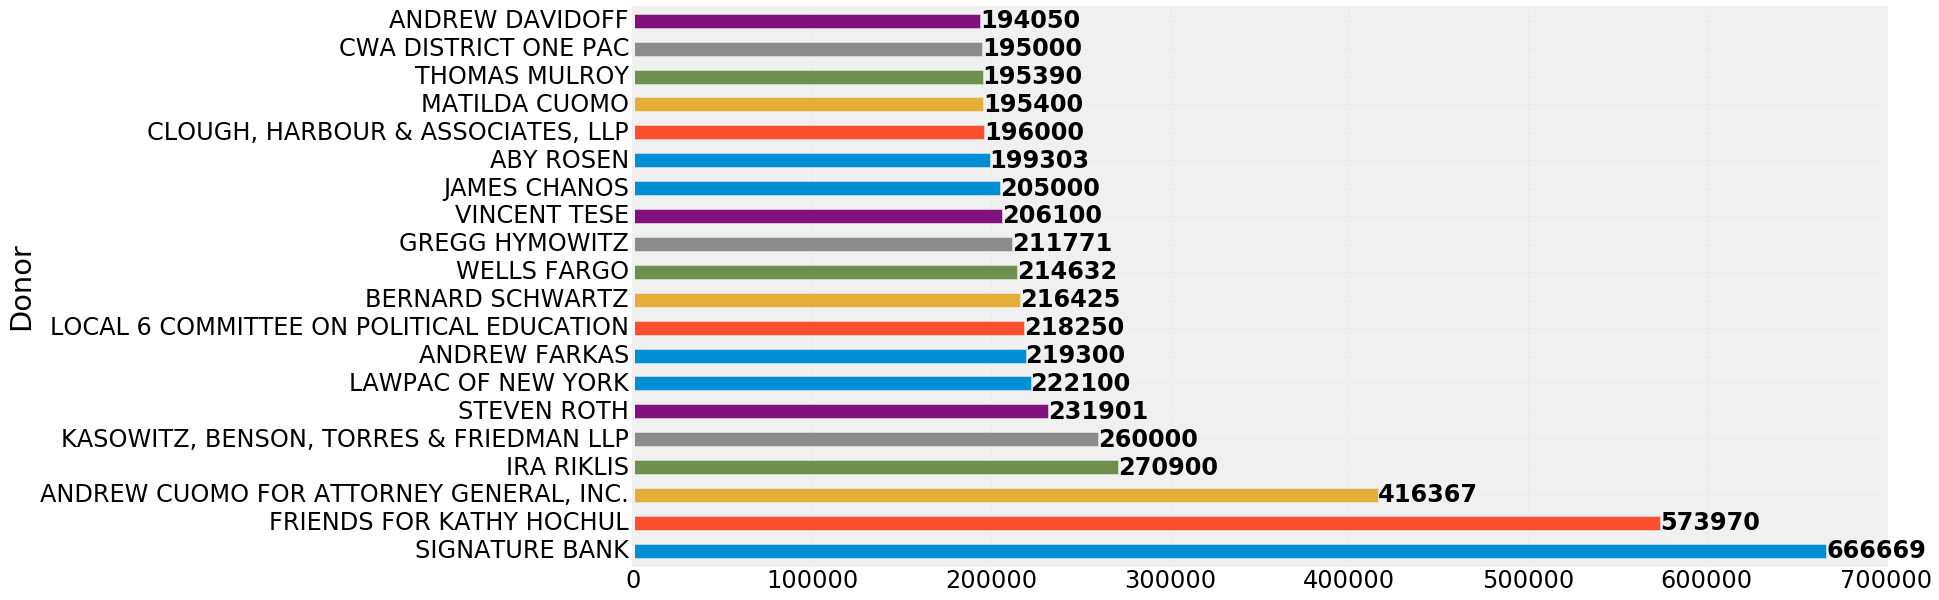

In [317]:
plt.figure(figsize=(20,10))
ax=df\
.groupby('Donor')['Amount_boe']\
.sum().sort_values(ascending=False).head(20)\
.plot(y='Amount_boe', x='Donor', kind='barh')

for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')
plt.savefig('topdonors.pdf')

*Signature bank*
- Ivanka Trump is on the board of directors
- Barney Frank is on the board of directors
- Ron Wasserman is an "associate group director", and is a member of AIPAC and chairman of Fuel for Truth, an anti-muslim think tank-funded org

*Kathy Hochul*
- Lieutenant governor of NYS
- "Friends for Kathy Hochul" receives money from LLC's, donates to Cuomo
- Kathy Hochul is heavily invested in the oil industry

*Kasowitz Benson Torres Friedman LLP*
- major RNC donor ($251,900)
- Trump donor
- https://projects.propublica.org/trump-town/organizations/kasowitz-benson-torres-friedman-llp !!!

## But wait!
> Shouldn't donors like Olga Rovt and Alexander Rovt (they're married) go together?
>Shouldn't we know that Dan Tishman is heavily invested in real estate?
>And if someone gives from an exact business address that is attributable to a company that has business before the >State of New York, we should know. Cuomo does, after all.

In [318]:
print("Over the years, Glenwood has officially given", df[df['Parent_Org_or_Employer'].str.contains("GLENWOOD", na=False)]['Amount_boe'].sum(), "to Cuomo's campaign.")
print("My analysis shows that they have given much, much more through their various LLC's and officers.")

Over the years, Glenwood has officially given 889400.0 to Cuomo's campaign.
My analysis shows that they have given much, much more through their various LLC's and officers.


## I want to start attributing parent organizations to addresses and donor names
- this means a lot of research, and using Pandas to match names.
- Only exact matches were used: if an address was not attributable to only one firm, it was not included.

In [319]:
def get_first_matches():
    df.loc[df['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'Parent_Org_or_Employer']='NIXON PEABODY LLP'
    df.loc[df['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'General_Industry']='Real Estate'
    df.loc[df['Donor'].str.contains("NIXON PEABODY", na=False), 'Parent_Org_or_Employer']='NIXON PEABODY LLP'
    df.loc[df['Donor'].str.contains("NIXON PEABODY", na=False), 'General_Industry']='Real Estate'

    #These are some entities that I know are Real Estate donors: Fisher Brothers, and Brookfield Properties, NORSTAR.
    #May 18, 2017, Cuomo announces renewal of 421a. One day later, May 19, 2017, he receives 159,000

    #Fisher Brothers
    df.loc[df['Donor'].str.contains("FISHER BROTHERS", na=False), 'General_Industry']='Real Estate'
    df.loc[df['Donor'].str.contains("FISHER BROTHERS", na=False), 'Parent_Org_or_Employer']='FISHER BROTHERS'
    df.loc[df['Address']=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'General_Industry']='Real Estate'
    df.loc[df['Address']=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'Parent_Org_or_Employer']='FISHER BROTHERS'

    #Brookfield
    df.loc[df['Donor'].str.contains("BOP", na=False), 'General_Industry']='Real Estate'
    df.loc[df['Donor'].str.contains("BOP", na=False), 'Parent_Org_or_Employer']='BROOKFIELD PROPERTY GROUP'

    #Longpoint Capital
    df.loc[df['Donor'].str.contains("CLOUGH, HARBOUR", na=False), 'Parent_Org_or_Employer']='Longpoint Capital'
    df.loc[df['Donor'].str.contains("CLOUGH, HARBOUR", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

    #NORSTAR
    df.loc[((df['General_Industry'] == 'Uncoded') & (df['Donor'].str.contains("NORSTAR"))), 'General_Industry']='Real Estate'

    #RXR, REXSCOTT
    df.loc[df['Donor'].str.contains("REXSCOTT", na=False), 'Parent_Org_or_Employer']='RXR REALTY'
    df.loc[((df['General_Industry'] == 'Uncoded') & (df['Donor'].str.contains("REXSCOTT"))), 'General_Industry']='Real Estate'
    df.loc[df['Donor'].str.contains("RXR", na=False), 'Parent_Org_or_Employer']='RXR REALTY'
    df.loc[df['Donor'].str.contains("RXR", na=False), 'General_Industry']='Real Estate'
    df.loc[df['Donor'].str.contains('R X R REALTY', na=False),'Parent_Org_or_Employer']='RXR REALTY'
    df.loc[df['Donor'].str.contains('R X R REALTY', na=False),'General_Industry']='Real Estate'
    df.loc[df['Address']=='625 RXR PLZ UNIONDALE, NY, 11556', 'Parent_Org_or_Employer']='RXR REALTY'
    df.loc[df['Address']=='625 RXR PLZ UNIONDALE, NY, 11556', 'General_Industry']='Real Estate'

    #STV
    df.loc[df['Donor'].str.contains(r"\bSTV\b", na=False), 'Parent_Org_or_Employer']='STV Incorporated'
    df.loc[df['Donor']=="STV", 'General_Industry']='Construction Services'
    df.loc[df['Donor']=="STV", 'Parent_Org_or_Employer']='STV Incorporated'
    df.loc[df['Address']=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'Parent_Org_or_Employer'] = 'STV Incorporated'
    df.loc[df['Address']=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'General_Industry']='Construction Services'
    df.loc[df['Donor']=='MILO RIVERSO', 'Parent_Org_or_Employer'] = 'STV Incorporated'
    df.loc[df['Donor']=='MILO RIVERSO', 'General_Industry']='Construction Services'
    df.loc[df['Donor']=='DOMINICK SERVEDIO', 'Parent_Org_or_Employer'] = 'STV Incorporated'
    df.loc[df['Donor']=='DOMINICK SERVEDIO', 'General_Industry']='Construction Services'
    df.loc[df['Donor']=='WILLIAM MATTS', 'Parent_Org_or_Employer'] = 'STV Incorporated'
    df.loc[df['Donor']=='WILLIAM MATTS', 'General_Industry']='Construction Services'

    #Project Compassion
    df.loc[df['Address']=='STE 146 11315 RANCHO BERNARDO RD SAN DIEGO, CA, 92127', 'General_Industry']='Nonprofit Institutions'
    df.loc[df['Address']=='STE 146 11315 RANCHO BERNARDO RD SAN DIEGO, CA, 92127', 'Parent_Org_or_Employer']='Project Compassion'

    #Nixon Peabody, LLP
    df.loc[df['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'Parent_Org_or_Employer']='NIXON PEABODY LLP'
    df.loc[df['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'General_Industry']='Lawyers & Lobbyists'

    #List of subsidiaries of Cablevision, from: https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
    cablevision_list = ["1015 TIFFANY STREET", "1047 E 46TH STREET", "111 NEW SOUTH ROAD", "1111 STEWART",
    "1144 ROUTE 109 CORP.", "151 S. FULTON STREET", "2234 FULTON STREET", "389 ADAMS STREET", "4CONNECTIONS",
    "A-R CABLE SERVICES - NY", "BBHI HOLDINGS", "CCG HOLDINGS", "Clearview Cinemas", "CORAM ROUTE 112",
    "CSC ACQUISITION - MA", "CSC ACQUISITION - NY", "CSC ACQUISITION", "CSC GATEWAY", "CSC INVESTMENTS",
    "CSC MVDDS", "CSC NASSAU II", "CSC OPTIMUM HOLDINGS", "CSC T HOLDINGS I", "CSC T HOLDINGS II",
    "CSC T HOLDINGS III", "CSC T HOLDINGS IV", "CSC TECHNOLOGY", "CSC TKR",
    "CSC TRANSPORT II", "CSC TRANSPORT III", "CSC TRANSPORT", "CSC VT", "DTV NORWICH",
    "Clearband", "FROWEIN ROAD", "LIGHTPATH VOIP", "MSG VARSITY NETWORK", "MSG Varsity Network",
    "MSGVN", "N12N", "NEWS 12 COMPANY", "News 12", "NEWSDAY", "NMG HOLDINGS", "NY OV LLC", "PETRA CABLEVISION CORP.",
    "PRINCETON VIDEO IMAGE ISRAEL", "PVI HOLDINGS", "PVI PHILIPPINES", "PVI VIRTUAL MEDIA SERVICES",
    "RAINBOW MVDDS COMPANY", "RASCO HOLDINGS", "RMVDDS", "OMGFAST!", "SAMSON CABLEVISION CORP.",
    "SUFFOLK CABLE", "TELERAMA", "THE NEW YORK INTERCONNECT", "TRISTATE DIGITAL GROUP", "WIFI CT-NJ", "WIFI NY"]
    #https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
    for shell in cablevision_list:    
        df.loc[df['Donor'].str.contains(shell, re.IGNORECASE, na=False), 'Parent_Org_or_Employer']='Cablevision Systems'
        df.loc[df['Donor'].str.contains(shell, re.IGNORECASE, na=False), 'General_Industry']='Cable TV'

    df.loc[df['Donor'] == 'NY OV LLC', 'Parent_Org_or_Employer']='Cablevision Systems'
    df.loc[df['Donor'] == 'NY OV LLC', 'General_Industry']='Cable TV'


    #Anthony Bacchi, founder of Teli Stat, recipient of 5 million NY state grant, also CEO of Restorative Continuum, LLC
    df.loc[df['Donor']=='RESTORATIVE CONTINUUM LLC', 'General_Industry']='Health Services'
    df.loc[df['Donor']=='RESTORATIVE CONTINUUM LLC', 'Parent_Org_or_Employer']='Teli Stat'

    df.loc[df['Address']== '30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354', 'General_Industry']='Real Estate'
    df.loc[df['Address']== '30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354', 'Parent_Org_or_Employer']='TRIANGLE EQUITIES'


    #Macquesten, their president, and their principal
    #Also '3300 KOSSUTH PARTNERS LLC' is a subsidiary: https://opengovus.com/new-york-state-corporation/4737731
    df.loc[df['Address']== 'STE 100 438 FIFTH AVE PELHAM, NY, 10803', 'General_Industry']='General Contractors'
    df.loc[df['Address']== 'STE 100 438 FIFTH AVE PELHAM, NY, 10803', 'Parent_Org_or_Employer']='Macquesten Development'
    df.loc[df['Address']=='STE 100, 438 FIFTH AVE PELHAM, NY, 10803', 'General_Industry']='General Contractors'
    df.loc[df['Address']=='STE 100, 438 FIFTH AVE PELHAM, NY, 10803', 'Parent_Org_or_Employer']='Macquesten Development'
    df.loc[df['Address']== '438 FIFTH AVE PELHAM, NY, 10803', 'General_Industry']='General Contractors'
    df.loc[df['Address']== '438 FIFTH AVE PELHAM, NY, 10803', 'Parent_Org_or_Employer']='Macquesten Development'
    df.loc[df['Donor']== 'RELLA FOGLIANO', 'General_Industry']='General Contractors'
    df.loc[df['Donor']== 'RELLA FOGLIANO', 'Parent_Org_or_Employer']='Macquesten Development'
    df.loc[df['Donor']== 'JOSEPH BREDA', 'General_Industry']='General Contractors'
    df.loc[df['Donor']== 'JOSEPH BREDA', 'Parent_Org_or_Employer']='Macquesten Development'
    df.loc[df['Donor']=='PALMER COURT ASSOCIATES, LLC', 'Parent_Org_or_Employer']='Macquesten Development'
    df.loc[df['Donor']=='PALMER COURT ASSOCIATES, LLC', 'General_Industry']='General Contractors'

    #This address corresponds to Carson Equities, LLC:
    #http://carson-equities.com/contact/
    df.loc[df['Address']== '4111 ANDOVER RD BLOOMFIELD TOWN, MI, 48302', 'General_Industry']= 'Real Estate'

    #STGG Realty LLC/Aro Holdings LLC
    df.loc[df['Donor']=='STGG REALTY LLC', 'General_Industry']='Real Estate'
    df.loc[df['Donor']=='STGG REALTY LLC', 'Parent_Org_or_Employer']='Aro Holdings LLC'

    #SFA
    df.loc[df['Address']=='RM 2800 675 3RD AVE NEW YORK, NY, 10017', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
    df.loc[df['Address']=='RM 2800 675 3RD AVE NEW YORK, NY, 10017', 'Parent_Org_or_Employer']='SFA'

    #State Street Title Agency
    df.loc[df['Address']=='2R 2413 3RD AVE BRONX, NY, 10451', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
    df.loc[df['Address']=='2R 2413 3RD AVE BRONX, NY, 10451', 'Parent_Org_or_Employer']='State Street Title Agency'

    #BUILDING TRADES EMPLOYERS ASSOCIATION OF NEW YORK CITY
    df.loc[df['Address']=='RM 1106 1430 BROADWAY NEW YORK, NY, 10018', 'Parent_Org_or_Employer']='BUILDING TRADES EMPLOYERS ASSOCIATION OF NEW YORK CITY'
    df.loc[df['Address']=='RM 1106 1430 BROADWAY NEW YORK, NY, 10018', 'General_Industry']='General Contractors'

    #US Immigration Fund and Nicholas Mastroianni
    #Subject of letter to Kushner Companies: https://advance-lexis-com.ezproxy.cul.columbia.edu/document/?pdmfid=1516831&crid=6477e7ad-e14b-46dc-90ee-04cff06df089&pddocfullpath=%2Fshared%2Fdocument%2Fnews%2Furn%3AcontentItem%3A5NP2-5X81-DYVR-P1JM-00000-00&pddocid=urn%3AcontentItem%3A5NP2-5X81-DYVR-P1JM-00000-00&pdcontentcomponentid=247474&pdteaserkey=sr0&pditab=allpods&ecomp=cy3k&earg=sr0&prid=90da6d5c-476c-447a-b7a3-5c6610ef4ac9
    df.loc[df['Address']=='80 STATE ST ALBANY, NY, 12207', 'Parent_Org_or_Employer']='US Immigration Fund'
    df.loc[df['Address']=='80 STATE ST ALBANY, NY, 12207', 'General_Industry']='Securities & Investment'

    df.loc[df['Donor']=='CONIFER REALTY LLC', 'Parent_Org_or_Employer']='Conifer Realty'
    df.loc[df['Donor']=='CONIFER REALTY LLC', 'General_Industry']='Real Estate'

## In fact, there were so many REBNY member overlaps, I decided to scrape the REBNY directory so I could cross-reference with the contributions data
- I used Selenium, a python library for web testing that is sometimes also used to scrape interactive pages, where you need to "click" a button

In [320]:
#LAST RUN 7/18/2018 DO NOT RUN
def scrape_rebny():
    driver = webdriver.Chrome()

    driver.get('https://www.rebny.com/content/rebny/en/directory/complete-member-directory.html/')
    rebny_list = []
    first = True;
    for page in range(797):
        time.sleep(2)
        table = driver.find_element_by_class_name('list')
        page_list=[]
        try:
            table = table.find_element_by_tag_name('tbody')
            rows = table.find_elements_by_tag_name('tr')
            for row in rows:
                name = row.find_elements_by_tag_name('td')[0].text
                firm = row.find_elements_by_tag_name('td')[1].text
                page_list.append({'name': name,
                         'firm': firm})
        except:
            pass

        rebny_list.append(page_list)

        if first:
            next_button = driver.find_element_by_xpath('//*[@id="dirInner"]/div/a[8]')
            first = False;
            next_button.click()
        else:
            next_button = driver.find_element_by_xpath('//*[@id="dirInner"]/div/a[9]')
            next_button.click()

    frames = []
    for reb in rebny_list:
            frames.append(pd.DataFrame(reb))

    rebny_df = pd.concat(frames, ignore_index=True)
    rebny_df['rebny']=1
    rebny_df['name']=rebny_df['name'].str.upper()
    rebny_df['firm']=rebny_df['firm'].str.upper()
    rebny_df.head()
    rebny_df[rebny_df['name']=='JONATHAN MILLER']
    rebny_df=rebny_df.drop_duplicates('name')
    rebny_df.to_csv("07182018rebny.csv")

## Real estate firms use many LLC's to donate unlimited amounts of money to Cuomo's political campaign. Glenwood, Resnick, Durst, Steiner, Roxann  all use many LLC's for their donations.

In [321]:
def get_re_matches():
    #Walison Corporation, Sabah Rajput
    df.loc[df['Donor']=='1060 UNIVERSITY AVE LLC','General_Industry']='Real Estate'
    df.loc[df['Donor']=='1060 UNIVERSITY AVE LLC','Parent_Org_or_Employer']='Walison Corporation'
    df.loc[df['Donor']=='2238 CRESTON AVENUE LLC','General_Industry']='Real Estate'
    df.loc[df['Donor']=='2238 CRESTON AVENUE LLC','Parent_Org_or_Employer']='Walison Corporation'

    #Glenwood has contributed lots to Cuomo under "Glenwood", but they also use shell LLC's to donate lots more!
    glenwood =['TRIBECA NORTH END LLC', 'BARCLAY STREET REALTY LLC',
               'LIBERTY STREET REALTY LLC', 'EAST 103RD STREET REALTY LLC',
               '92ND REALTY LLC', 'ARWIN 74TH STREET LLC',
               'EAST 72ND REALTY LLC', 'EAST 81ST REALTY, LLC'
               'EAST 85TH REALTY LLC', 'EAST 77TH REALTY LLC']
    for glen in glenwood:
        df.loc[df['Donor']==glen, 'Parent_Org_or_Employer']='GLENWOOD MANAGEMENT CORP.'
        df.loc[df['Donor']==glen, 'General_Industry']='Real Estate'

    df.loc[df['Address']=='1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040' , 'Parent_Org_or_Employer']='GLENWOOD MANAGEMENT CORP.'
    df.loc[df['Address']=='1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040' , 'General_Industry']='Real Estate'

    resnick = ['315 HUDSON LLC', '250 HUDSON STREET LLC',
               'RESNICK SEAPORT LLC','133 E 58TH STREET LLC',
               '161 WILLIAM STREET LLC','AB 40TH STREET LLC', 
               'RESNICK 255 GREENWICH LLC', 'RB 52 CO. LLC', 
               'DENNIS BRADY']

    for res in resnick:
        df.loc[df['Donor']==res, 'Parent_Org_or_Employer']='RESNICK, JACK & SONS'
        df.loc[df['Donor']==res, 'General_Industry']='Real Estate'

    #Durst
    esposito = ['DOLP 733 PROPERTIES LLC', 'DOLP 1155 PROPERTIES LLC',
                'DOLP 1133 PROPERTIES LLC','DOLP 675 PROPERTIES LLC',
                'DOLP 205 PROPERTIES LLC', 'DOLP 114 PROPERTIES LLC',
                'THE HELENA ASSOCIATES LLC', 'THE DURST ORGANIZATION, LP',
                'HELENA DURST', 'ALEXANDER DURST']
    for esp in esposito:
        df.loc[df['Donor']==esp, 'Parent_Org_or_Employer']='THE DURST ORGANIZATION'
        df.loc[df['Donor']==esp, 'General_Industry']='Real Estate'

    #Steiner Equities Group
    steiner = ['25 WA ASSOCIATES LLC', '181 AVENUE A, LLC', '25WA ASSOCIATES, LLC']
    for stein in steiner:
        df.loc[df['Donor']==stein, 'Parent_Org_or_Employer']='STEINER NYC, LLC'
        df.loc[df['Donor']==stein, 'General_Industry']='Real Estate'
    df.loc[df['Address']=='75 EISENHOWER PARKWAY ROSELAND, NJ, 07068', 'Parent_Org_or_Employer']='STEINER NYC, LLC'
    df.loc[df['Address']=='75 EISENHOWER PARKWAY ROSELAND, NJ, 07068', 'General_Industry']='Real Estate'

    #Roxann Management Corp
    roxann = ['203 WEST 90TH STREET RETAIL LLC', '1628 SECOND AVENUE RETAIL LLC',
              '170 WEST 75TH STREET RETAIL LLC',
               '215 WEST 90TH STREET RETAIL LLC']
    for rox in roxann:
        df.loc[df['Donor']==stein, 'Parent_Org_or_Employer']='Roxann Management Corp'
        df.loc[df['Donor']==stein, 'General_Industry']='Real Estate'
    df.loc[df['Donor'] == 'CURTIS KATZ', 'Parent_Org_or_Employer']='Roxann Management Corp'
    df.loc[df['Donor'] == 'CURTIS KATZ','General_Industry']='Real Estate'    

    #Orbach Group
    orbach = ['BEACON 109 203-205, LLC', 'LIGHTHOUSE 49 LLC']
    for orb in orbach:
        df.loc[df['Donor']==orb, 'Parent_Org_or_Employer']='Orbach Group'
        df.loc[df['Donor']==orb, 'General_Industry']='Real Estate'
    df.loc[df['Donor']=='PO BOX 1524 ENGLEWOOD CLIFF, NJ, 07632', 'Parent_Org_or_Employer']='Orbach Group'
    df.loc[df['Donor']=='PO BOX 1524 ENGLEWOOD CLIFF, NJ, 07632', 'General_Industry']='Real Estate'

    #Atlantic Development Group
    atlantic = ['MARC ALTHEIM', 'PETER FINE', 'KNICKERBOCKER MANAGEMENT LLC','KNICKERBOCKER MANAGEMENT, LLC']
    for atl in atlantic:
        df.loc[df['Donor']==atl, 'Parent_Org_or_Employer']='ATLANTIC DEVELOPMENT GROUP, LLC'
        df.loc[df['Donor']==atl, 'General_Industry']='Real Estate'

    #MADDD Equities
    maddd = ["JACKSON BUILDERS, LLC","ST. ANN'S CDE OWNER LLC", 'MADDD EQUITIES LLC']
    for mad in maddd:
        df.loc[df['Donor']==mad, 'Parent_Org_or_Employer']='MADDD Equities'
        df.loc[df['Donor']==mad, 'General_Industry']='Real Estate'


    #Clover, Michael Joseph, Howard Zemsky
    clover = ["10 SULTAN'S COURT BUFFALO, NY, 14221",
              "10 SULTAN'S COURT WILLIAMSVILLE, NY, 14221",
              "10 SULTANS CT WILLIAMSVILLE, NY, 14221",
              "348 HARRIS HILL ROAD WILLIAMSVILLE, NY, 14221"]

    for clov in clover:
        df.loc[df['Address']==clov, 'Parent_Org_or_Employer']='Clover Construction'
        df.loc[df['Address']==clov, 'General_Industry']='Real Estate'

    # FOUR M HOLDINGS
    df.loc[df['Donor'].str.contains("MEHIEL", na=False), 'Parent_Org_or_Employer']='Four M Holdings'
    df.loc[df['Donor'].str.contains("MEHIEL", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
    df.loc[df['Donor'] == 'FOUR M CAPITAL, LLC', 'Parent_Org_or_Employer']='Four M Holdings'
    df.loc[df['Donor']=='FOUR M FRANCHISING, LLC', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

    # Rovt
    df.loc[df['Donor'].str.contains(r"ROVT$", na=False), 'Parent_Org_or_Employer']='Rovt'

## on paper, REBNY showers money on Cuomo with PACs. But also through its members!
+ REBNY firm members-- especially its executive committee-- also give money individually.
+ Typically they give money themselves; their firms give money; and their families give money. So how much does an organization like Durst really give?
+ First I'll match some names from qualitative research.
+ Then I'll join my data with the member list I scraped from REBNY; exact matches on donor name will relate any uncategorized donors to their parent organization.


In [322]:
def get_rebny_matches():
    #MEMBERS
    #Related- Bruce Beal
    df.loc[df['Donor'].str.contains("BRUCE BEAL", na=False), 'Parent_Org_or_Employer']='RELATED COMPANIES, L.P.'
    df.loc[df['Donor'].str.contains("BRUCE BEAL", na=False), 'General_Industry']='Real Estate'

    #Extell- Gary Barnett
    df.loc[df['Donor'].str.contains("GARY BARNETT", na=False), 'Parent_Org_or_Employer']='EXTELL DEVELOPMENT COMPANY'
    df.loc[df['Donor'].str.contains("GARY BARNETT", na=False), 'General_Industry']='Real Estate'

    #The Brodsky Organization- Daniel Brodsky
    df.loc[df['Address']=='FL 3 400 W 59TH ST NEW YORK, NY, 10019', 'Parent_Org_or_Employer']='THE BRODSKY ORGANIZATION'
    df.loc[df['Address']=='FL 3 400 W 59TH ST NEW YORK, NY, 10019', 'General_Industry']='Real Estate'

    #BFC Partners- Donald Capoccia
    df.loc[df['Donor'].str.contains("CAPOCCIA", na=False), 'Parent_Org_or_Employer']='BFC PARTNERS'
    df.loc[df['Donor'].str.contains("CAPOCCIA", na=False), 'General_Industry']='Real Estate'            

    #Rockrose Development Corp. and TF Cornerstone Inc.
    df.loc[df['Donor'].str.contains("ELGHA", na=False), 'Parent_Org_or_Employer']='ELGHANAYAN FAMILY'
    df.loc[df['Donor'].str.contains("ELGHA", na=False), 'General_Industry']='Real Estate' 

    #Fetner Properties Inc.- Harold A. Fetner and Sondra Fetner
    df.loc[df['Donor'].str.contains("SONDRA FETNER", na=False), 'Parent_Org_or_Employer']='FETNER PROPERTIES INC'
    df.loc[df['Donor'].str.contains("SONDRA FETNER", na=False), 'General_Industry']='Real Estate'
    df.loc[df['Donor'].str.contains("HAROLD A. FETNER", na=False), 'Parent_Org_or_Employer']='FETNER PROPERTIES INC'
    df.loc[df['Donor'].str.contains("HAROLD A. FETNER", na=False), 'General_Industry']='Real Estate'

    #Newmark Knight Frank- Barry Gosin and Jackie Gosin
    df.loc[df['Donor'].str.contains("GOSIN", na=False), 'Parent_Org_or_Employer']='NEWMARK KNIGHT FRANK'
    df.loc[df['Donor'].str.contains("GOSIN", na=False), 'General_Industry']='Real Estate'

    #SL Green- Stephen Green and Marc Holliday
    df.loc[df['Donor'].str.contains("SL GREEN", na=False), 'Parent_Org_or_Employer']='SL GREEN REALTY CORP.'
    df.loc[df['Donor'].str.contains("SL GREEN", na=False), 'General_Industry']='Real Estate'
    df.loc[df['Donor']=='STEPHEN GREEN', 'Parent_Org_or_Employer']='SL GREEN REALTY CORP.'
    df.loc[df['Donor']=='STEPHEN GREEN', 'General_Industry']='Real Estate'
    df.loc[df['Donor']=='MARC HOLLIDAY', 'Parent_Org_or_Employer']='SL GREEN REALTY CORP.'
    df.loc[df['Donor']=='MARC HOLLIDAY', 'General_Industry']='Real Estate'

    #GF Real Estate LLP- JEFFREY GURAL
    df.loc[df['Donor']=='JEFFRY GURAL', 'Parent_Org_or_Employer']='GFP REAL ESTATE LLC'
    df.loc[df['Donor']=='JEFFRY GURAL', 'General_Industry']='Real Estate'
    #Kalikow, H.J. & Co., LLC: the whole family, it seems
    kalikow=['H.J. KALIKOW & CO LLC', 'MARY KALIKOW',
             'PETER KALIKOW','KALIKOW CONSTRUCTION SERVICES']
    for kow in kalikow:
        df.loc[df['Donor']==kow, 'Parent_Org_or_Employer']='KALIKOW, H.J. & CO., LLC'
        df.loc[df['Donor']==kow, 'General_Industry']='Real Estate'

    #Two Trees Management Company, LLC
    df.loc[df['Donor'].str.contains("TWO TREES", na=False), 'Parent_Org_or_Employer']='TWO TREES MANAGEMENT CO. LLC'
    df.loc[df['Donor'].str.contains("TWO TREES", na=False), 'General_Industry']='Real Estate'

    #Sterling Equities - Fred Wilpon
    df.loc[df['Donor'].str.contains("STERLING EQUITIES", na=False),'Parent_Org_or_Employer']='STERLING EQUITIES, INC.'
    df.loc[df['Donor'].str.contains("STERLING EQUITIES", na=False), 'General_Industry']='Real Estate'

    #Tishman -- at 666 5th Avenue, Kushner's building
    tishman=["DAN TISHMAN","SHERYL CRO TISHMAN", "JOHN TISHMAN",
             "TISHMAN SPEYER DEVELOPMENT, LLC","SHERYL TISHMAN",
            "TISHMAN CONSTRUCTION CORP OF NY","TISHMAN SPEYER DEVELOPMENT LLC"]
    for tish in tishman:
        df.loc[df['Donor']==tish, 'Parent_Org_or_Employer']='TISHMAN SPEYER'
        df.loc[df['Donor']==tish, 'General_Industry']='Real Estate'

    #Lalezarian Properties LLC- Frank and Kevin Lalezarian
    df.loc[df['Address'].str.contains('2 SPLIT ROCK DRIVE KINGS',na=False), 'Parent_Org_or_Employer']='LALEZARIAN PROPERTIES LLC'
    df.loc[df['Address'].str.contains('2 SPLIT ROCK DRIVE KINGS',na=False), 'General_Industry']='Real Estate'


## They also give money through PACs.

In [323]:
def get_pac_matches():
    #REBNY PAC, their political arm, "Real Estate Board PAC"
    df.loc[df['Donor'].str.contains("REAL ESTATE BOARD", na=False), 'Parent_Org_or_Employer']='REBNY'
    df.loc[df['Donor'].str.contains("REAL ESTATE BOARD", na=False), 'General_Industry']='Real Estate'

    #NYSAFAH has a PAC, 'Affordable Housing PAC, Ltd.'
    df.loc[df['Donor'].str.contains("AFFORDABLE HOUSING PAC", na=False), 'Parent_Org_or_Employer']='NYSAFAH'
    df.loc[df['Donor'].str.contains("AFFORDABLE HOUSING PAC", na=False), 'General_Industry']='Real Estate'

    #Also has NYSAFAH PAC LTD.
    df.loc[df['Donor'].str.contains("NYSAFAH PAC LTD.", na=False), 'Parent_Org_or_Employer']='NYSAFAH'
    df.loc[df['Donor'].str.contains("NYSAFAH PAC LTD.", na=False), 'General_Industry']='Real Estate'
    df.loc[df['Address']=='FRNT 3 242 W 36TH ST NEW YORK, NY, 10018', 'General_Industry']= 'Real Estate'
    df.loc[df['Address']=='FRNT 3 242 W 36TH ST NEW YORK, NY, 10018', 'Parent_Org_or_Employer']='NYSAFAH'

    #RPAC OF NEW YORK STATE- "Realtor PAC"
    df.loc[df['Donor'].str.contains("RPAC OF NEW YORK STATE", na=False), 'Parent_Org_or_Employer']='Realtors PAC'
    df.loc[df['Donor'].str.contains("RPAC OF NEW YORK STATE", na=False), 'General_Industry']='Real Estate'



## But as far as NYC slumlords, RSA may be a bigger player than REBNY.
## Only they don't publish their member list. Whistleblowers get at me!
- "i think of REBNY as like the sort of suits"
- "...and RSA as like the old school new york thugs"
- "REBNY for example is like 'sure, we believe in green building and energy efficiency! corporate responsibility'
- "...and RSA is like 'fuck your planet'"

In [324]:
def get_rsa_matches():
    #Ditmas Management - Sanford Sirulnick, Aaron Sirulnick, his son, is RSA chairman of the board
    df.loc[df['Donor'].str.contains("SIRULNICK", na=False), 'Parent_Org_or_Employer']='RSA Ditmas Management'
    df.loc[df['Donor'].str.contains("SIRULNICK", na=False), 'General_Industry']='Real Estate'

    #Leonard Litwin - Glenwood Management - covered above

    #Howard Milstein - CEO of New York Private Bank; Chairman of Emigrant Capital
    df.loc[df['Donor'].str.contains("MILSTEIN", na=False), 'Parent_Org_or_Employer']='RSA Emigrant Capital'
    df.loc[df['Donor'].str.contains("MILSTEIN", na=False), 'General_Industry']='Real Estate'

    #Dennis Brady - Resnick - covered above

    #Michael Kerr - RSA Boardmember, what else?
    df.loc[df['Donor'].str.contains("MICHAEL KERR", na=False), 'Parent_Org_or_Employer']='RSA'
    df.loc[df['Donor'].str.contains("MICHAEL KERR", na=False), 'General_Industry']='Real Estate'

In [325]:
def get_last_matches():
    #About fifteen firms that are uncoded and have realty in their name. They are definitely Real Estate.
    df.loc[(df['General_Industry'].str.contains("Uncoded",na=False))&(df['Donor'].str.contains("REALTY", na=False)), 'General_Industry']='Real Estate'
    #Eastdil Secured is a "premier real estate investment bank"
    df.loc[df['Address']=='40 WEST 57TH STREET NEW YORK, NY, 10019', 'Parent_Org_or_Employer']='Eastdil Secured'
    df.loc[df['Address']=='40 WEST 57TH STREET NEW YORK, NY, 10019', 'General_Industry']='Real Estate'

    #Richman Group
    df.loc[df['Address']=='340 PEMBERWICK ROAD GREENWICH, CT, 06831', 'Parent_Org_or_Employer']='Richman Group'
    df.loc[df['Address']=='340 PEMBERWICK ROAD GREENWICH, CT, 06831', 'General_Industry']='Real Estate'

In [326]:
#Here's my list of REBNY firms/members from their member directory

rebny_df = pd.read_csv("rebny.csv")
rebny_df = rebny_df.drop_duplicates('name', keep='first')
df = pd.merge(df, rebny_df, left_on='Donor', right_on='name', how='left')
df.columns
df['Date'] = pd.to_datetime(df['Date_boe'], infer_datetime_format=True)
df = df.set_index('Date')
df.sort_index(inplace=True)
df.head()

,Donor,Address,Check No.,Amount_boe,Date_boe,Recipient,Transaction Code,Contribution Code,Fiscal Report,Filing_Jurisdiction,...,Broad_Sector,City,State,Zip,In-State,Parent_Org_or_Employer,Unnamed: 0,firm,name,rebny
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-28,MATT GOHD,"650 5TH AVENUE NEW YORK, NY, 10019",CC,16000.0,01/28/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-28,MATT GOHD,"650 5TH AVENUE NEW YORK, NY, 10019",CC,14700.0,01/28/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-01,LYNDA SIROTA,"1 PALLISAR ROAD IRVINGTON, NY, 10533",CC,14700.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-01,GEORGE MCDONALD,"232 84TH STREET NEW YORK, NY, 10028",CC,1000.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-01,RICHARD SIROTA,"1 PALLISAR ROAD IRVINGTON, NY, 10533",CC,10000.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [327]:
reb_list = list(set(rebny_df['firm']))
#Also, if they're in REBNY, categorize as REBNY
df.loc[df['Parent_Org_or_Employer'].isin(reb_list),'rebny']=1
df.loc[df['Parent_Org_or_Employer'].isin(reb_list),'General_Industry']='Real Estate'

In [328]:
df['Parent_Org_or_Employer']=df['Parent_Org_or_Employer'].astype(object).fillna('Unknown')
def fill_parent(row):
    if row['Parent_Org_or_Employer']=='Unknown':
        return row['firm']
    else:
        return row['Parent_Org_or_Employer']

In [329]:
df['Parent_Org_or_Employer'] = df.apply(fill_parent, axis=1)

In [330]:
df[df['Parent_Org_or_Employer']=='FISHER BROTHERS']['Address'].unique()

array(['4 MCDONALD PLACE SCARSDALE, NY, 10583',
       '299 PARK AVENUE NEW YORK, NY, 10171',
       '4 MCDONALD PL SCARSDALE, NY, 10583',
       '189 W 89TH ST NEW YORK, NY, 10024',
       '425 EAST 58TH STREET NEW YORK, NY, 10171',
       '260 MADISON AVENUE NEW YORK, NY, 10019',
       '425 EAST 58TH STREET NEW YORK, NY, 10022'], dtype=object)

In [331]:
rec = df['2017-01-01':]
print("Sum from Real Estate 2017-2018:", "${:,}".format(rec[rec['General_Industry']=='Real Estate']['Amount_boe'].sum()))
print("Sum from Lawyers, Lobbyists and Trade unions 2017-2018:", "${:,}".format(rec[(rec['General_Industry']=='Lawyers & Lobbyists')|(rec['General_Industry']=='Trade Unions')]['Amount_boe'].sum()))

Sum from Real Estate 2017-2018: $375,013.61
Sum from Lawyers, Lobbyists and Trade unions 2017-2018: $528,572.0


## Well, I'd like to see what the parent org breakdown is for the real estate industry.
- Hopefully the REBNY list helped make that clearer:

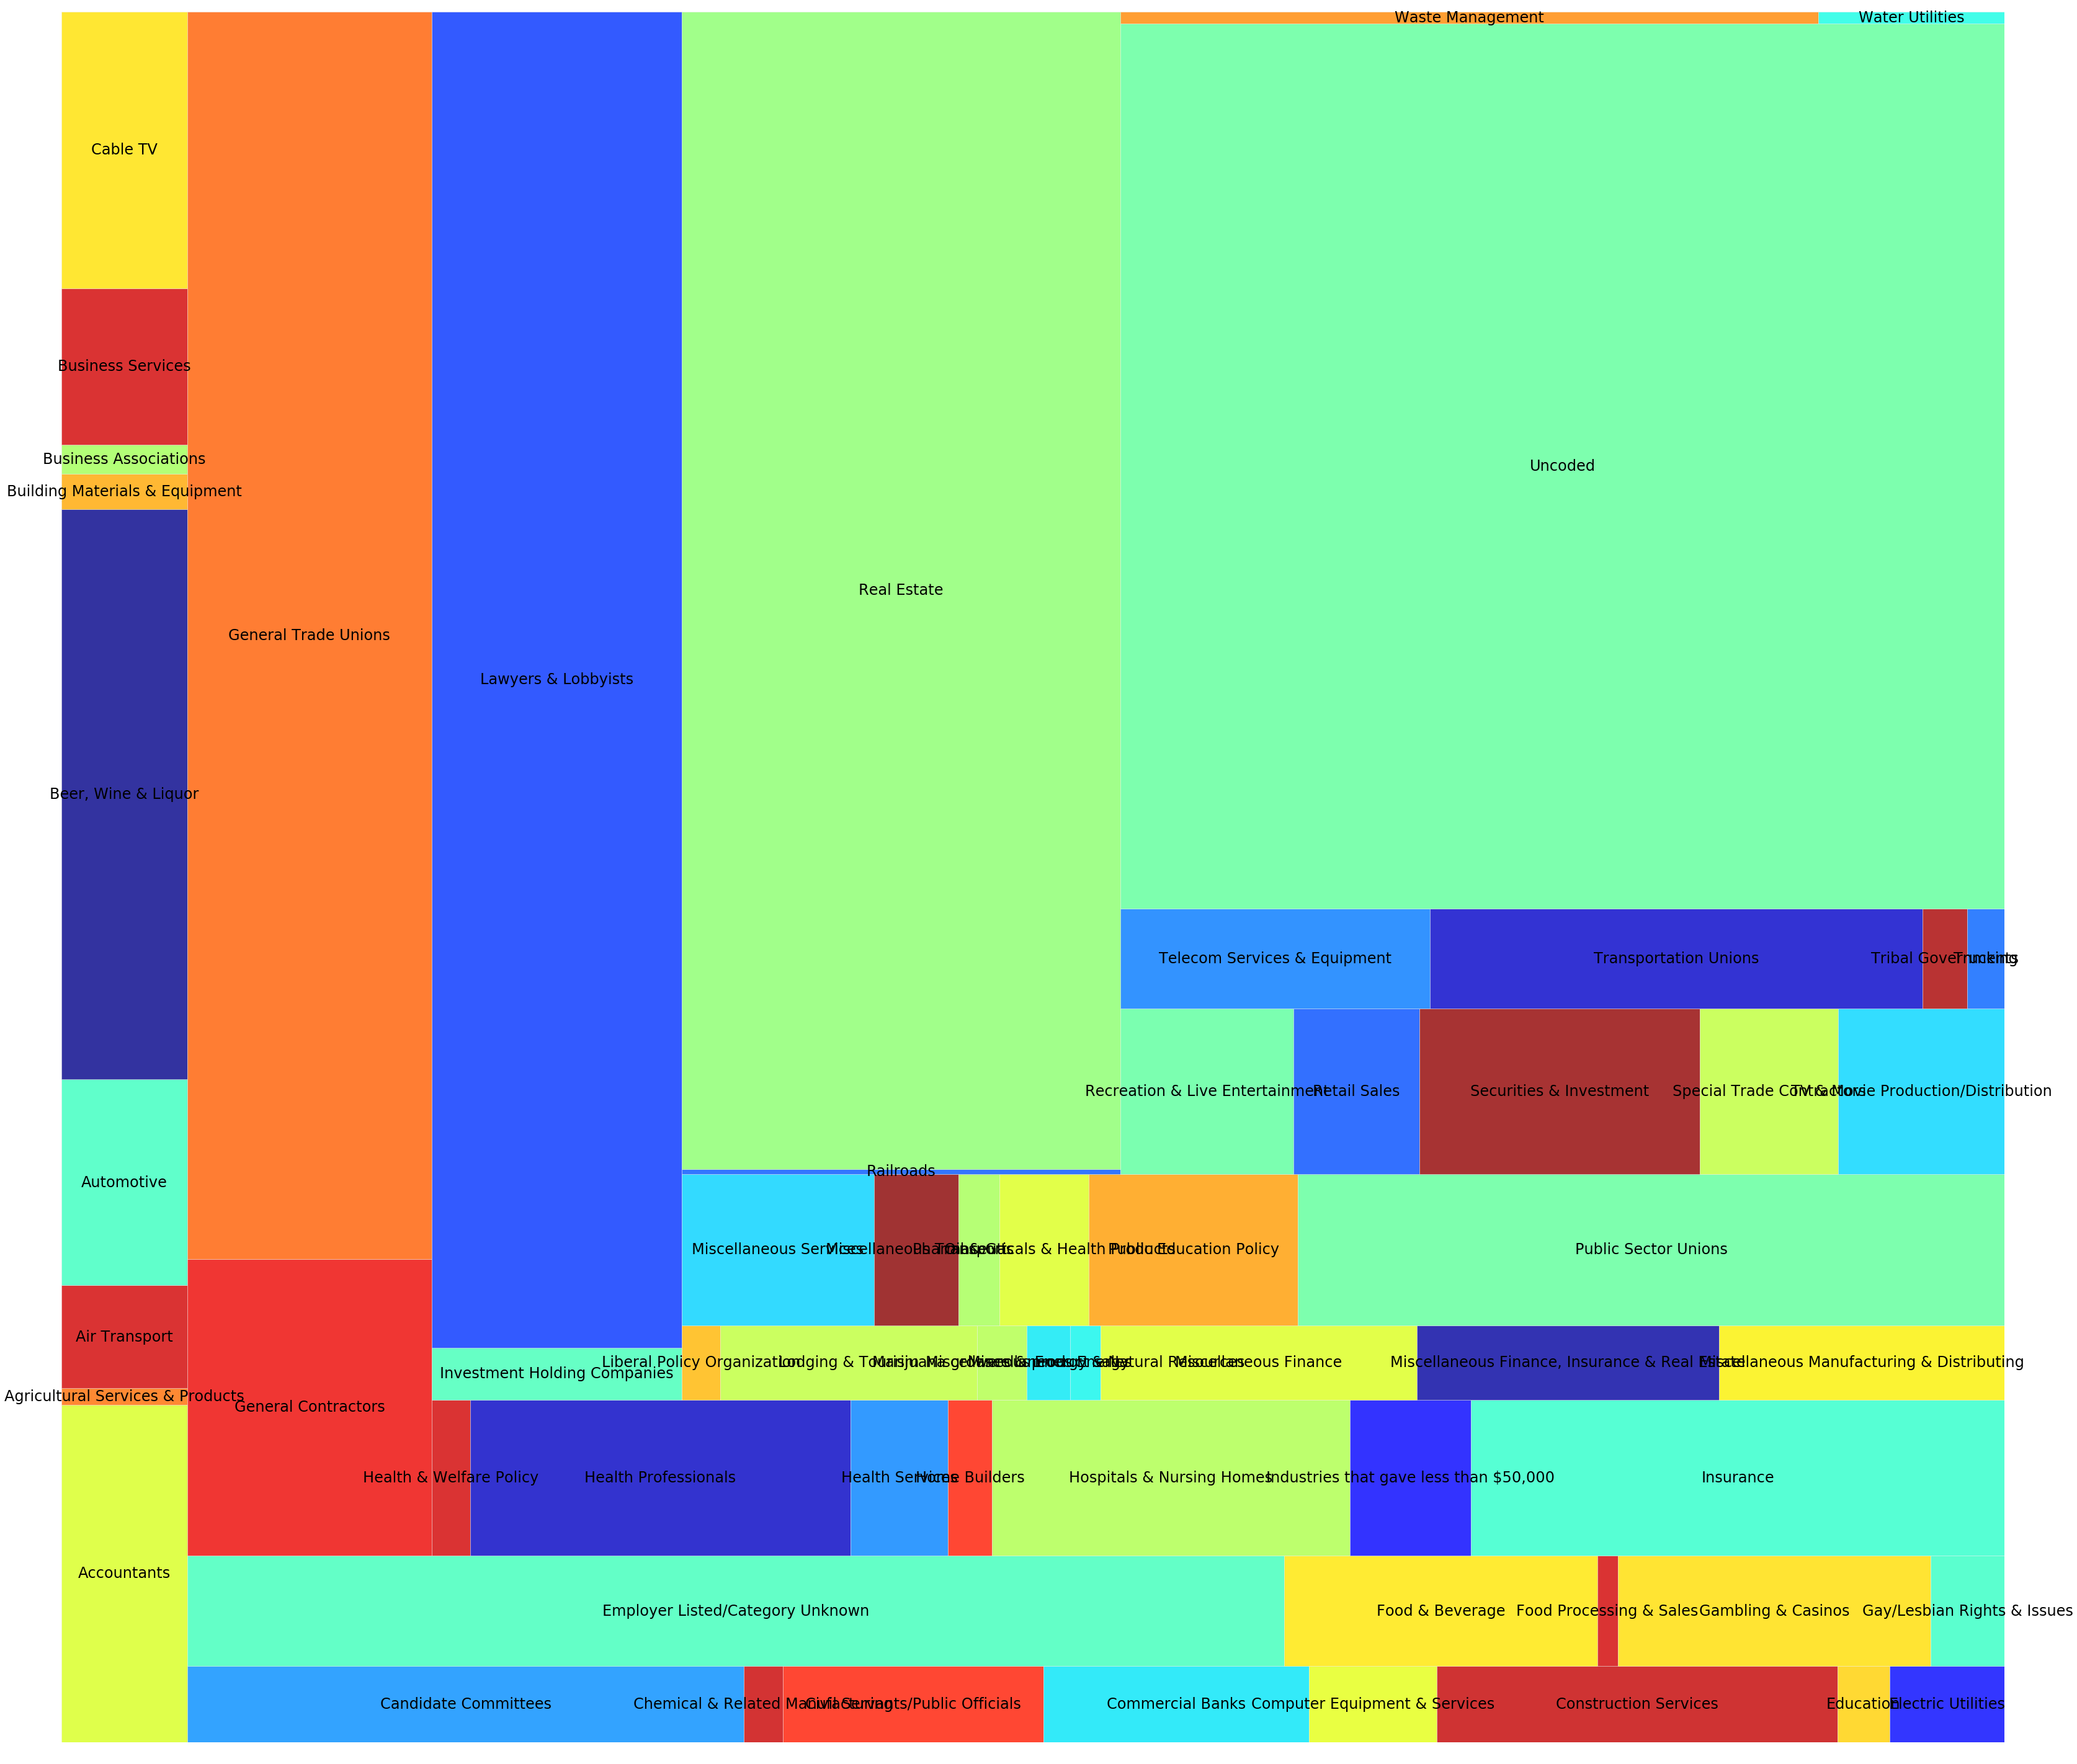

In [332]:
squares = df.groupby('General_Industry')['Amount_boe'].sum().reset_index()

#Squarify does not like division by zero
squares.loc[squares['Amount_boe']<25000, 'General_Industry']='Industries that gave less than $50,000'
squares = squares.groupby('General_Industry')['Amount_boe'].sum().reset_index()

plt.figure(figsize=(50,50))
squarify.plot(sizes=squares['Amount_boe'], label=squares['General_Industry'], alpha=.8 )
plt.axis('off')
plt.show()

In [333]:
rsa_df = pd.read_csv("RSA-PAC-cleaned.csv")
rsa_df['Amount'] = rsa_df['Amount'].replace( '[\$,)]','', regex=True ).astype(float)
rsa_df['Name'] = rsa_df['Name'].str.strip()
rsa_df['Address']=rsa_df['Address'].str.strip()+' '+rsa_df['City'].str.strip()+' '+rsa_df['State'].str.strip()
rsa_add=list(set(rsa_df['Address']))
rsa_ind=list(set(rsa_df['Name']))

## Project Compassion NY LLC
- gave a one-time contribution of $50,000 on 12/13/2017
- Is based in California?? No idea what the connection is and probably not something we should pursue. Small fish!

## Restorative Continuum LLC
- CEO is Anthony Bachi, also the founder of Telistat, which is received a 5 million grant in 2016, and in August 2017 a Long Island facility got a 1.5 million grant to implement a Telistat Restorative Care Unit.
- https://www.prnewswire.com/news-releases/telistat-introduces-innovative-healthcare-unit-to-long-island-300501207.html

## RXR, REXSCOTT, GABELI... Various LLCs
- Gabeli and REXSCOTT each gave 65000 on the same date (05/19/2017). Gabeli may be the same as "The Gabeli Private Equity Fund"
-
- REXSCOTT, Gabeli, RXR all have the same address: '625 RXR PLZ UNIONDALE, NY, 11556'.
- I'm not sure if they are the same, related, renting the same space, etc.
- RXR = REXSCOTT, still not sure about Gabelli.
- The Real Deal "Earlier this year, Rechler was appointed by Cuomo to the board of the Metropolitan Transportation Authority and previously served on the board of the Port Authority of New York and New Jersey."
- RXR is a big Cuomo donor and was also covered by the Intercept recently (Cea Weaver pitched this story):
- https://theintercept.com/2018/07/12/andrew-cuomo-donations-ice/
- But the story just covers their connection to ICE, and RXR DEFINITELY gives to Cuomo not because of ICE but because of real estate, which is our framing.
- Cea told me off the record... 
    - "RXR bought this group Urban America/Renaissance Downtowns in like 2016 or 2017...and i think they have a strategy to like take over the suburbs in small towns in like Westchester, Nassau County that are on the LIRR or the Metro North they are hyper focused on increasing density. Typically that is met with really racist resistance. But like .... it's also an explict strategy to focus on profiting from people of color being pushed out of the city and like small towns in the suburbs don't have the urban planning infrastructure that New York City has, so what they are doing is essentially siphoning off and privatizing an essential City function of town planning and privatizing it. Making the plan. Doing the development. All of it."
    - "And of course Rechler is on the Board of the RPA...which is making a big deal about regional development and is super "respected" and a huge validator...and he uses it to valdiate his own projects"

## Triangle Equities
- Real Deal reported they gave 50,000, but they actually gave 75,000 total in 2017 (and have been a big donor since 2011, when they gave 25,000) if you count all of the LLCs that used the same Whitestone, NY address: 30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354
- 496 WEST JERICHO TURNPIKE LLC, TRIANGLE EQUITIES JUNCTION LLC, 755 CO-OP CITY LLC
- Their big "Lighthouse Point" project was delayed in the senate: https://therealdeal.com/2015/12/18/state-senate-delays-funding-for-lighthouse-point-project/

## Macquesten Development LLC
- Donated 40,000 in 4 separate donations on 5/18/2017 and 12/15/2017
- 3 different LLCs, all from the same address: STE 100 438 FIFTH AVE PELHAM, NY, 10803	
- Also their principals are big donors (and named as donors):

    - Rella Fogliano – President, 111000 total given to Cuomo as of January 2018
    - Joseph Breda – Principal/Special Projects Manager, 85,000 total given to Cuomo as of January 2018
    
## Maple Heights Sub, LLC
- Gave 20,000 and 30,000 to cuomo from the same address, within 2 weeks at the end of 2017/beginning of 2018.
- Open Corporates says 700 N Sam Houston Road Realty LLC used to be named: 
    - 700 N. SAM HOUSTON ROAD REALTY, LLC
    - FOUR M HOLDINGS II, LLC
- Bloomberg lists Four M. Holdings as "specialty finance" and they have deep pockets, one of their affiliates bought an 80,000,000 collection of production facilities, one of which is in New York. Paul Hastings brags about it here: https://www.paulhastings.com/news/details/?id=d97fd769-2334-6428-811c-ff00004cbded

## STGG Realty LLC
- Donation total: 50,000 on 9/26/2017
- Owned by Steven E Plotnick according to a DOB application for a development that was declined: http://a810-bisweb.nyc.gov/bisweb/JobsQueryByNumberServlet?requestid=3&passjobnumber=321501987&passdocnumber=01
- Business address: 227 EAST 58TH STREET NEW YORK NY 10022
- Aro Holdings, LLC is also registered to Steven Plotnick, at the same address
- DOS ID: 4111399
- Can't find anything about Aro Holdings, LLC except that they are a landlord here: 18 EAST 68 STREET, MANHATTAN
- Don't seem to own any other buildings

## NYSAFAH PAC (New York State Association for Affordable Housing PAC)
- This is a very misleading name
- They have people in common with RSA (!)
- 400 members: real estate entities
- Have given tons of money to Cuomo, from this address: FRNT 3 242 W 36TH ST NEW YORK, NY, 10018
- They also have received money from BFC, Norstar, NYS senate committee housekeeping

## PITTA & GIBLIN LLP, VINCENT PITTA, ANTOINETTE PITTA, PITTA BISHOP DEL GIORNO & GIBLIN LLC, PITTA LLP
- Donation total: 245798.0
- From not very many addresses:
    '120 BROADWAY NEW YORK, NY, 10022'
    '120 BROADWAY NEW YORK, NY, 10271'
    '124 OVERLOOK TERRACE STATEN ISLAND, NY, 10305'
    'ATTN VINCENTPITTA, 120 BROADWAY NEW YORK, NY, 10271'
    'FL 28, 120 BROADWAY NEW YORK, NY, 10271'
    '124 OVERLOOK TER STATEN ISLAND, NY, 10305'
    'FL 28 120 BROADWAY NEW YORK, NY, 10271'
   
## Orbach Group, Harry Tawil
- Donation total: 35,000
- Harry Tawil works at the Orbach Group, which was in the news recently for their aggressive and unlawful eviction cases against rent-controlled tenants: https://therealdeal.com/2018/05/21/these-are-the-industry-players-cited-in-the-massive-nyt-housing-investigation/
- They gave under a few names which I found in Department of Buildings filings data

## Steiner Equities Group
- 

## Atlantic Development Group, Peter Fine, Marc Altheim
- Donation total: 120,000
- Donations under various LLC's, Peter Fine, and Marc Altheim.
- Some LLC's found through DOB data: 'KNICKERBOCKER MANAGEMENT LLC','KNICKERBOCKER MANAGEMENT, LLC'
    - Registered to Marc Altheim
- Peter Fine was in a fight with Marc Altheim, who owns 80 percent of Atlantic: https://therealdeal.com/2017/06/19/developer-peter-fine-sued-for-allegedly-withholding-3-5m-from-partner/
- Atlantic Development Group "made millions by selling 421a certificates to developers"...
- "Affordable Housing Developer"

In [334]:
print("Joseph Breda has given: ", df[df['Donor']=='JOSEPH BREDA']['Amount_boe'].sum())
print("Rella Fogliano has given: ", df[df['Donor']=='RELLA FOGLIANO']['Amount_boe'].sum())

Joseph Breda has given:  85000.0
Rella Fogliano has given:  141000.0


In [335]:
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})
plt.rcdefaults()
plt.rcParams.update({
  'lines.linewidth': 0,
  'lines.solid_capstyle': 'butt',
  'legend.fancybox': True,
  'axes.prop_cycle': cycler('color', ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']),
  'axes.facecolor': '#f0f0f0',
  'axes.labelsize': 'large',
  'axes.axisbelow': True,
  'axes.grid': True,
  'axes.edgecolor': '#f0f0f0',
  'axes.linewidth': 3.0,
  'axes.titlesize': 'x-large',
  'patch.edgecolor': '#f0f0f0',
  'patch.linewidth': 0.5,
  'svg.fonttype': 'path',
  'grid.linestyle': ':',
  'grid.linewidth': .5,
  'grid.color': '#cbcbcb',
  'xtick.major.size': 0,
  'xtick.minor.size': 0,
  'ytick.major.size': 0,
  'ytick.minor.size': 0,
  'font.size': 14.0,
  'savefig.edgecolor': '#f0f0f0',
  'savefig.facecolor': '#f0f0f0',
  'figure.subplot.left': 0.08,
  'figure.subplot.right': 0.95,
  'figure.subplot.bottom': 0.07,
  'figure.facecolor': '#f0f0f0',
})


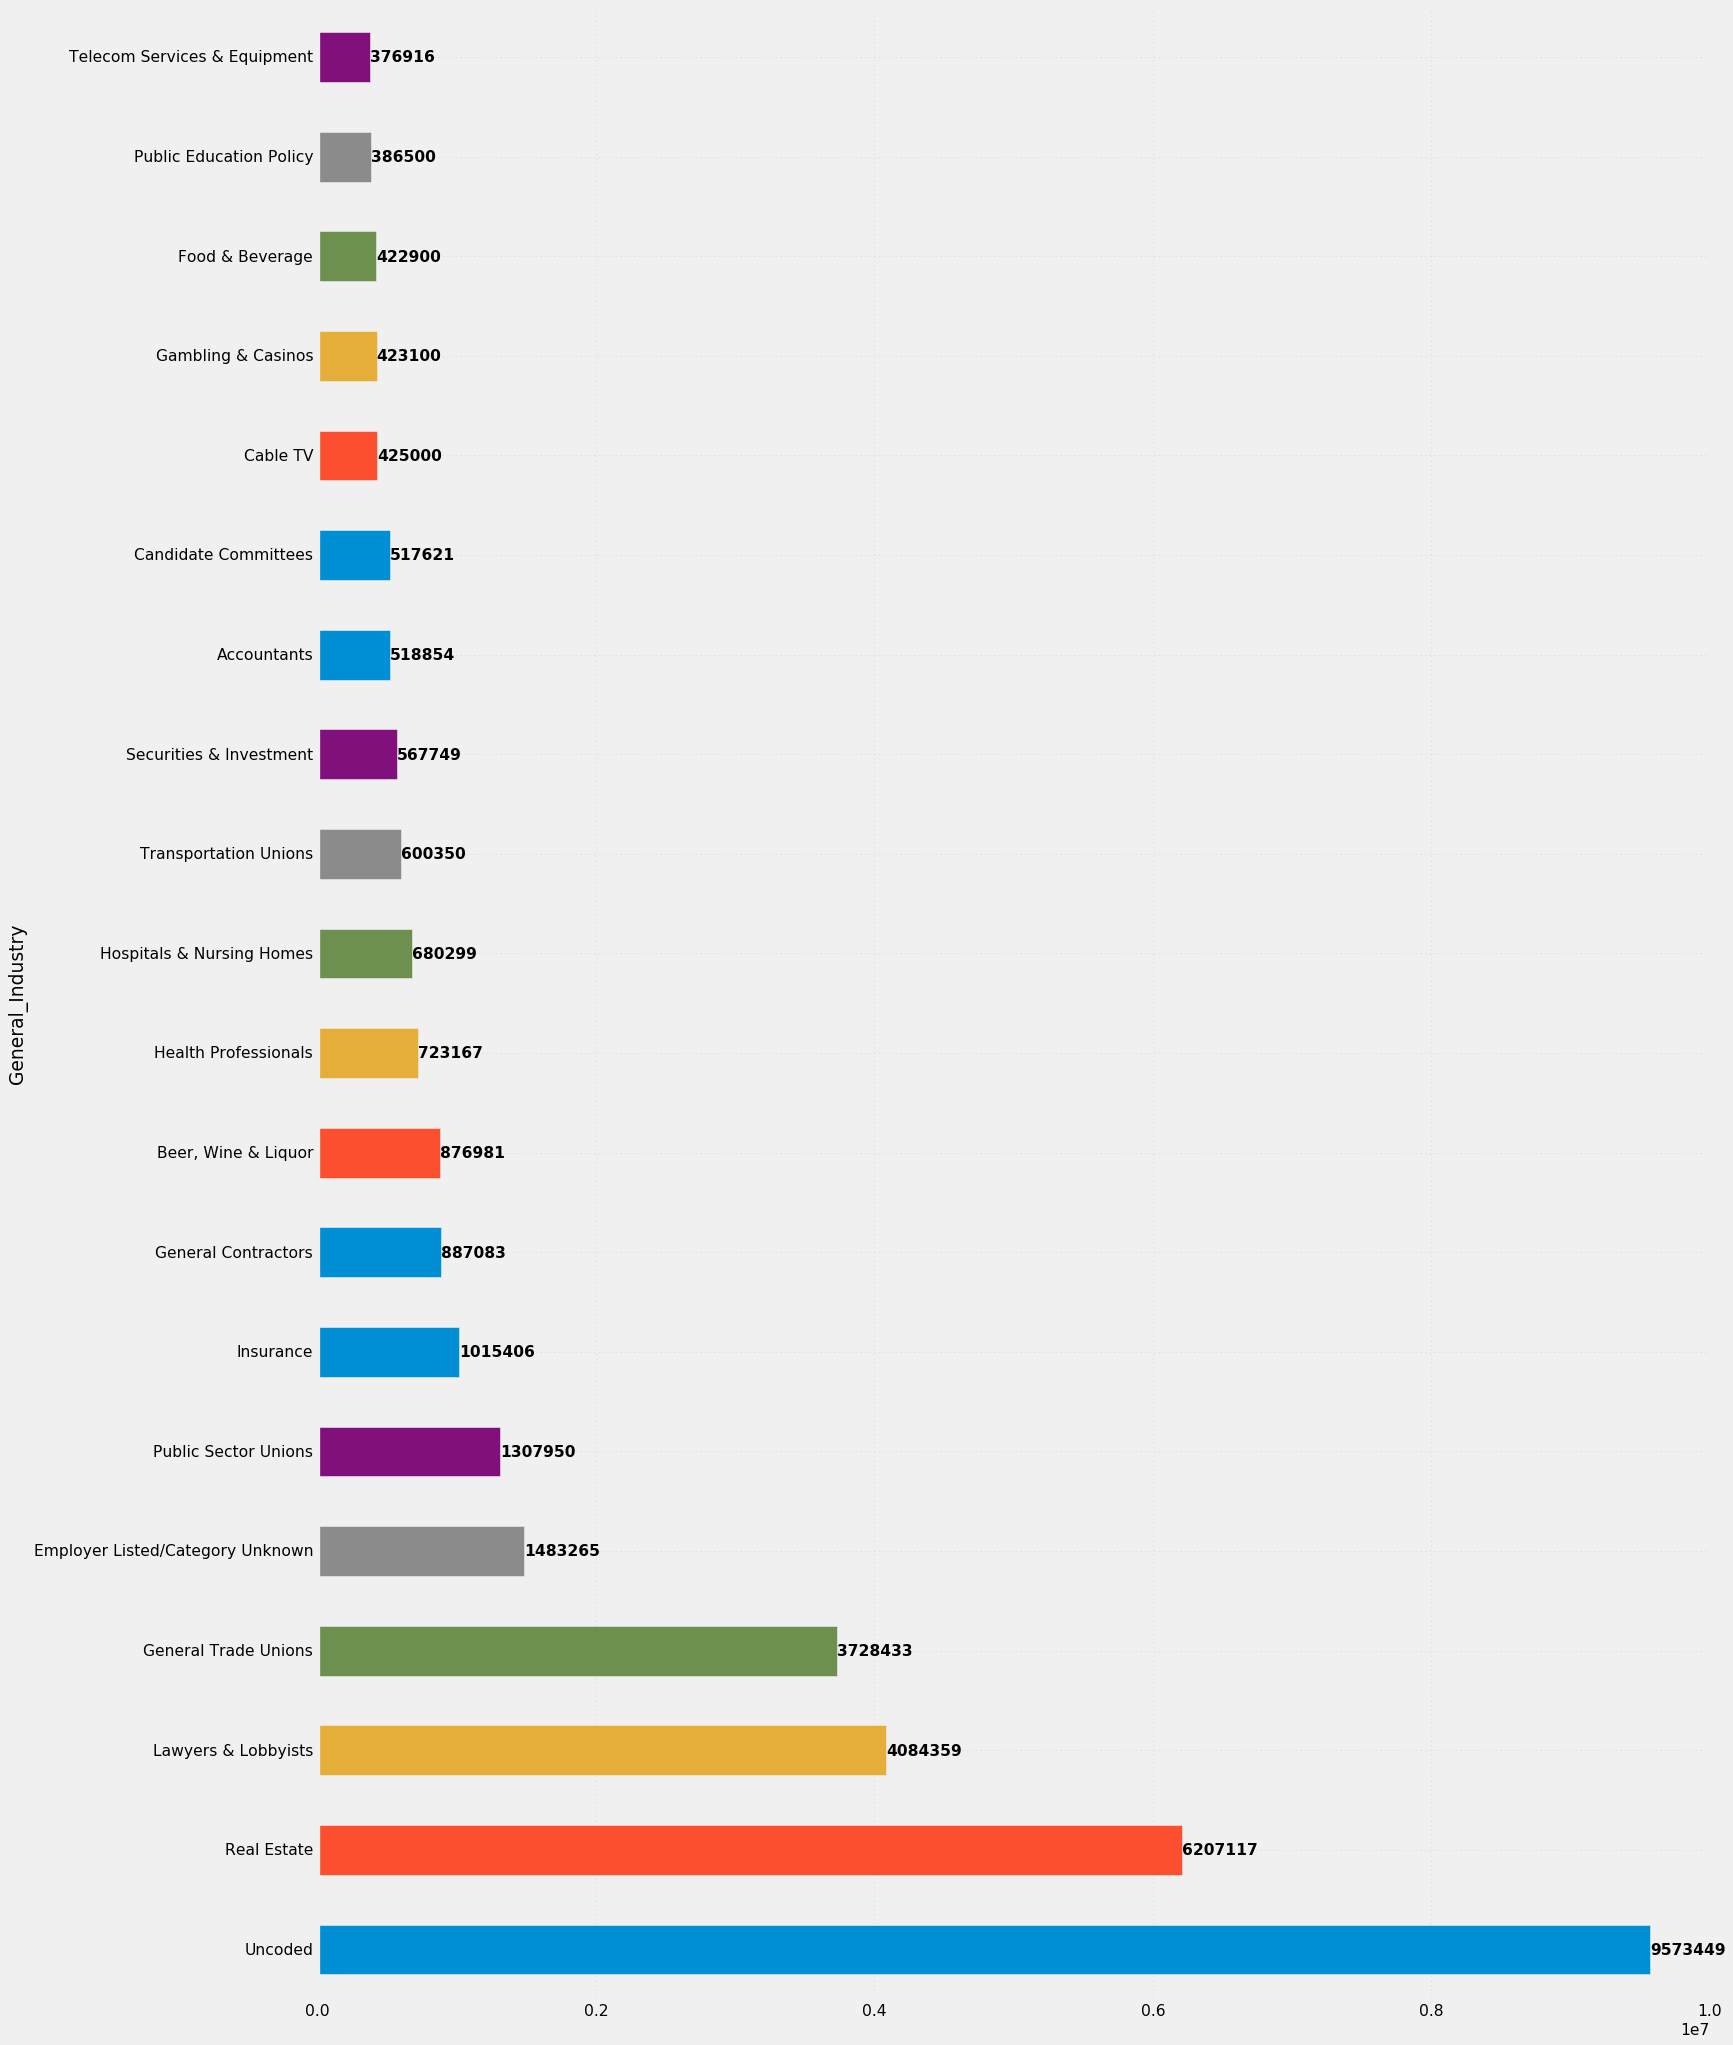

In [336]:
plt.figure(figsize=(20,30))
ax = df.groupby('General_Industry')['Amount_boe']\
.sum().sort_values(ascending=False).head(20)\
.plot(y='Amount_boe', x='General_Industry', kind='barh')

for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')

plt.savefig("topindustries.pdf")

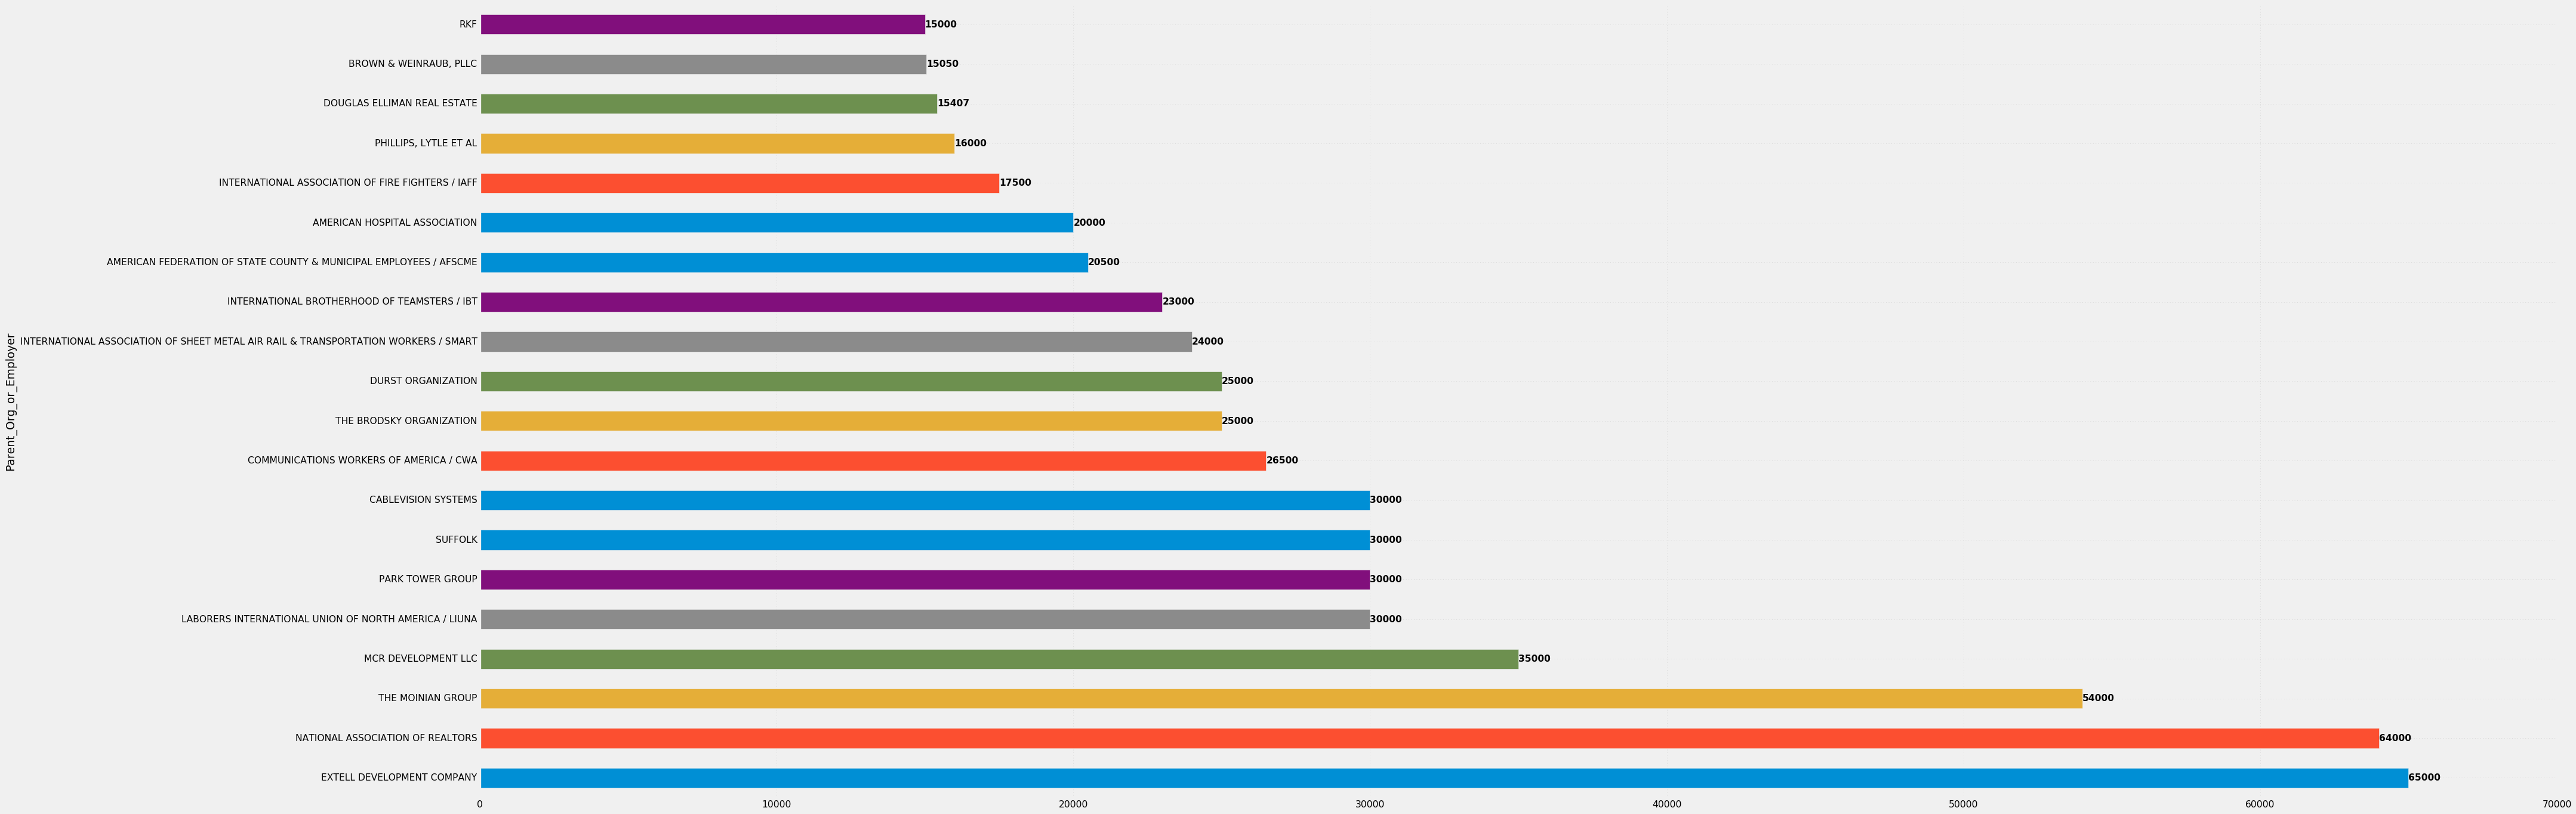

In [337]:
plt.figure(figsize=(50,20))
ax=df['2017-01-01':]\
.groupby('Parent_Org_or_Employer')['Amount_boe']\
.sum().sort_values(ascending=False).head(20)\
.plot(y='Amount_boe', x='Parent_Org_or_Employer', kind='barh')

for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')
plt.savefig('topdonors.pdf')

## Next I'm going to cross-reference the list of Cuomo donor LLCs with a nyc-db to see if there are any matches. It's not a big deal that they're in the DOB JOBS database, but they have to report an owner name: and that ownername might be in the REBNY or RSA list I have, or be connected to another donor already in BOE data.

## So I can answer the question: how many landlords used their shell LLC's for managing buildings, and also for donating to Cuomo?

I start by running the cuomo_llc_list.csv file through nyc-db's dobjobs table, to find exact matches-- this will be a "minimum" number. I find 132 unique LLCs that are both Cuomo donors and landlord LLCs.

In [338]:
#These are the LLC's I get by matching directly in SQL.
df_llc=pd.read_csv('cuomo_llc_list.csv')
df_llc['ownersphone']=df_llc['ownersphone'].astype(str)
df_llc['ownersbusinessname'].nunique()

132

## But for a more exhaustive list, I'm going to need a list of all the LLC's in New York City.

That looks like about 175,000 unique LLCs. I'm going to match them up to the Cuomo LLC's.
I run the following query on my local copy of nyc-db to get all of the LLC's from DOBJOBS in New York:

```CREATE TABLE nyc_llc AS SELECT ownersbusinessname, bbl, address FROM dobjobs WHERE ownersbusinessname LIKE('%LLC%') GROUP BY ownersbusinessname, bbl, address                                                                 ;
SELECT 175564
```

## I want more granular information on each LLC, how much they've given to Cuomo and when. 

So I won't just check to see if they match to some LLC in Cuomo's donor list: but confirm exactly which one(s) they match.

In [339]:
unknown_llc_number = df[(df['Donor'].str.contains('LLC'))|\
            (df['Broad_Sector']=='Unknown')|\
            (df['General_Industry']=='Unknown')|\
            (df['Specific_Business']=='Unknown')|\
            (df['Parent_Org_or_Employer']=='Unknown')]\
            ['Donor'].nunique()

llc_list = df[(df['Donor'].str.contains('LLC')) |\
            (df['Broad_Sector']=='Unknown')|\
            (df['General_Industry']=='Unknown')|\
            (df['Specific_Business']=='Unknown')|\
            (df['Parent_Org_or_Employer']=='Unknown')]

#Here I checked the LLC names against the LLCs listed in DOBJOBS

llc_list.columns = [c.lower() for c in llc_list.columns]
#postgres doesn't like capitals or spaces

engine = create_engine('postgresql://GeorgiaKromrei@localhost:5432/housing_data_analysis')

llc_list.to_sql("cuomo_llc_list", engine, if_exists="replace")
print("I'm loading", llc_list['donor'].nunique(), "unique LLC names into nyc-db for cross-referencing.")

#These are the LLC's I get by matching directly in SQL.

df_llc=pd.read_csv('cuomo_llc_list.csv')
df_llc['ownersphone']=df_llc['ownersphone'].astype(str)
df_llc['ownersbusinessname'].nunique()

#If I use Python, I get a few more

nyc_llc = pd.read_csv('nyc_llc.csv')
nyc_llc['businessname_nollc'] = nyc_llc['ownersbusinessname'].str.upper().str.replace(r',? LLC.*','')
llc_list['donorname_nollc'] = llc_list['donor'].str.replace(r',? LLC.*','')

unique = llc_list[llc_list['donorname_nollc'].isin(nyc_llc['businessname_nollc'])]['donor'].nunique()

print("There are", unique, '''unique LLC's in NYC-DB who have given to Cuomo's campaign that were unidentified by\
either Follow the Money or the Board of Elections.''')

llc_list = llc_list.merge(nyc_llc, right_on='businessname_nollc', left_on='donorname_nollc', how='inner')
llc_list.drop_duplicates('check no.', keep='first', inplace=True)
llc_list.ownername = llc_list.ownername.str.upper().str.replace("ESPOISTO", "ESPOSITO")\
                                        .str.replace("EDWARD KAMIN", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKI", "EDWARD KAMINSKY")\
                                        .str.replace("TIVADAR MARCOVICI", "TIVADAR MARCOVICCI")\
                                        .str.replace("EDWARD KAMINSKYSKI", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKYSKY", "EDWARD KAMINSKY")\
                                        .str.replace("JOHNATHAN", "JONATHAN")\
                                        .str.replace("PETRACCA LESTER", "LESTER PETRACCA")\
                                        .str.replace("LOIS ESPOSITO", "LOUIS ESPOSITO")\
                                        .str.replace("LEONARD LITWIM", "LEONARD LITWIN")
llc_list=llc_list[['donor','ownername', 'ownersbusinessname','address_y','ownersphone']]

llc_list.rename(columns={"ownername":"dob_ownername","address_y":"dob_address","ownersphone":"dob_ownersphone","ownersbusinessname":"dob_business"},inplace=True)

I'm loading 1681 unique LLC names into nyc-db for cross-referencing.
There are 218 unique LLC's in NYC-DB who have given to Cuomo's campaign that were unidentified byeither Follow the Money or the Board of Elections.


## Landlords who use shell LLC's to hide from their tenants, and also to donate to Cuomo. Let's see who uses the most different LLC's:

In [340]:
df['Original_Donor']=df['Donor']
llc_list = llc_list.drop_duplicates('donor', keep='first')
df = pd.merge(df, llc_list, left_on='Donor', right_on='donor', how='left')
df.head()

,Donor,Address,Check No.,Amount_boe,Date_boe,Recipient,Transaction Code,Contribution Code,Fiscal Report,Filing_Jurisdiction,...,Unnamed: 0,firm,name,rebny,Original_Donor,donor,dob_ownername,dob_business,dob_address,dob_ownersphone
0,MATT GOHD,"650 5TH AVENUE NEW YORK, NY, 10019",CC,16000.0,01/28/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,MATT GOHD,NaN,NaN,NaN,NaN,NaN
1,MATT GOHD,"650 5TH AVENUE NEW YORK, NY, 10019",CC,14700.0,01/28/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,MATT GOHD,NaN,NaN,NaN,NaN,NaN
2,LYNDA SIROTA,"1 PALLISAR ROAD IRVINGTON, NY, 10533",CC,14700.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,LYNDA SIROTA,NaN,NaN,NaN,NaN,NaN
3,GEORGE MCDONALD,"232 84TH STREET NEW YORK, NY, 10028",CC,1000.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,GEORGE MCDONALD,NaN,NaN,NaN,NaN,NaN
4,RICHARD SIROTA,"1 PALLISAR ROAD IRVINGTON, NY, 10533",CC,10000.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,NaN,RICHARD SIROTA,NaN,NaN,NaN,NaN,NaN


In [341]:
get_first_matches()
get_re_matches()
get_rebny_matches()
get_rsa_matches()
get_last_matches()

In [342]:
def transform_row(row):
    if not pd.isnull(row['dob_business']):
        row['Donor']=row['dob_business']
    return row
        
df = df.apply(transform_row,axis=1)

In [343]:
get_first_matches()
get_re_matches()
get_rebny_matches()
get_rsa_matches()
get_last_matches()

*Edward Kaminsky*
- a luxury real estate agent. Is he related to senator Todd Kaminsky?

*Jonathan Resnick*
- member of REBNY, who used 7 different LLC's to contribute to Cuomo
- for a total of $20,000$ all on the same day: November 16, 2017.
- The LLC's were all totally different, but registered to the same address. The donations were for $2,500 each.

*Louis Esposito* used 5 different LLC's to donate 212,500 to Cuomo.
- He is a lobbyist with Durst, according to Little Sis: https://littlesis.org/org/68088-Durst_Organization_Inc
- Durst is a member of REBNY.

*Leonard Litwin* (deceased) and *Charles Dorego* are both executives at *Glenwood Management*, Cuomo's biggest single donor. All together they've donated more than 1/2 million to Cuomo.

*Jorge Madruga*
-ceo of MADDD Equities and has also given to Marco Rubio

*Exact Capital*
-50,000 to Cuomo on January 9. Politico reported, Real Deal summarized: https://therealdeal.com/2017/01/23/cuomo-raises-4-4m-with-help-of-real-estate-donors/

*Sabah Rajput*
- Walison Corporation
- Affordable Housing Developer, https://commercialobserver.com/2017/03/sterling-lends-16m-on-bronx-affordable-housing-development-15-more-projects-on-the-way/

In [344]:
df['Amount_boe'].sum()

140087063.46

In [345]:
df['Date']=pd.to_datetime(df['Date_boe'], infer_datetime_format=True)
df['Donation_Date']=df['Date']
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head()

,Donor,Address,Check No.,Amount_boe,Date_boe,Recipient,Transaction Code,Contribution Code,Fiscal Report,Filing_Jurisdiction,...,firm,name,rebny,Original_Donor,donor,dob_ownername,dob_business,dob_address,dob_ownersphone,Donation_Date
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-28,MATT GOHD,"650 5TH AVENUE NEW YORK, NY, 10019",CC,16000.0,01/28/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,MATT GOHD,NaN,NaN,NaN,NaN,NaN,2001-01-28
2001-01-28,MATT GOHD,"650 5TH AVENUE NEW YORK, NY, 10019",CC,14700.0,01/28/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,MATT GOHD,NaN,NaN,NaN,NaN,NaN,2001-01-28
2001-02-01,LYNDA SIROTA,"1 PALLISAR ROAD IRVINGTON, NY, 10533",CC,14700.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,LYNDA SIROTA,NaN,NaN,NaN,NaN,NaN,2001-02-01
2001-02-01,GEORGE MCDONALD,"232 84TH STREET NEW YORK, NY, 10028",CC,1000.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,GEORGE MCDONALD,NaN,NaN,NaN,NaN,NaN,2001-02-01
2001-02-01,RICHARD SIROTA,"1 PALLISAR ROAD IRVINGTON, NY, 10533",CC,10000.0,02/01/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Monetary Contributions/Individual and Partnerships,Individual,Periodic July,NaN,...,NaN,NaN,NaN,RICHARD SIROTA,NaN,NaN,NaN,NaN,NaN,2001-02-01


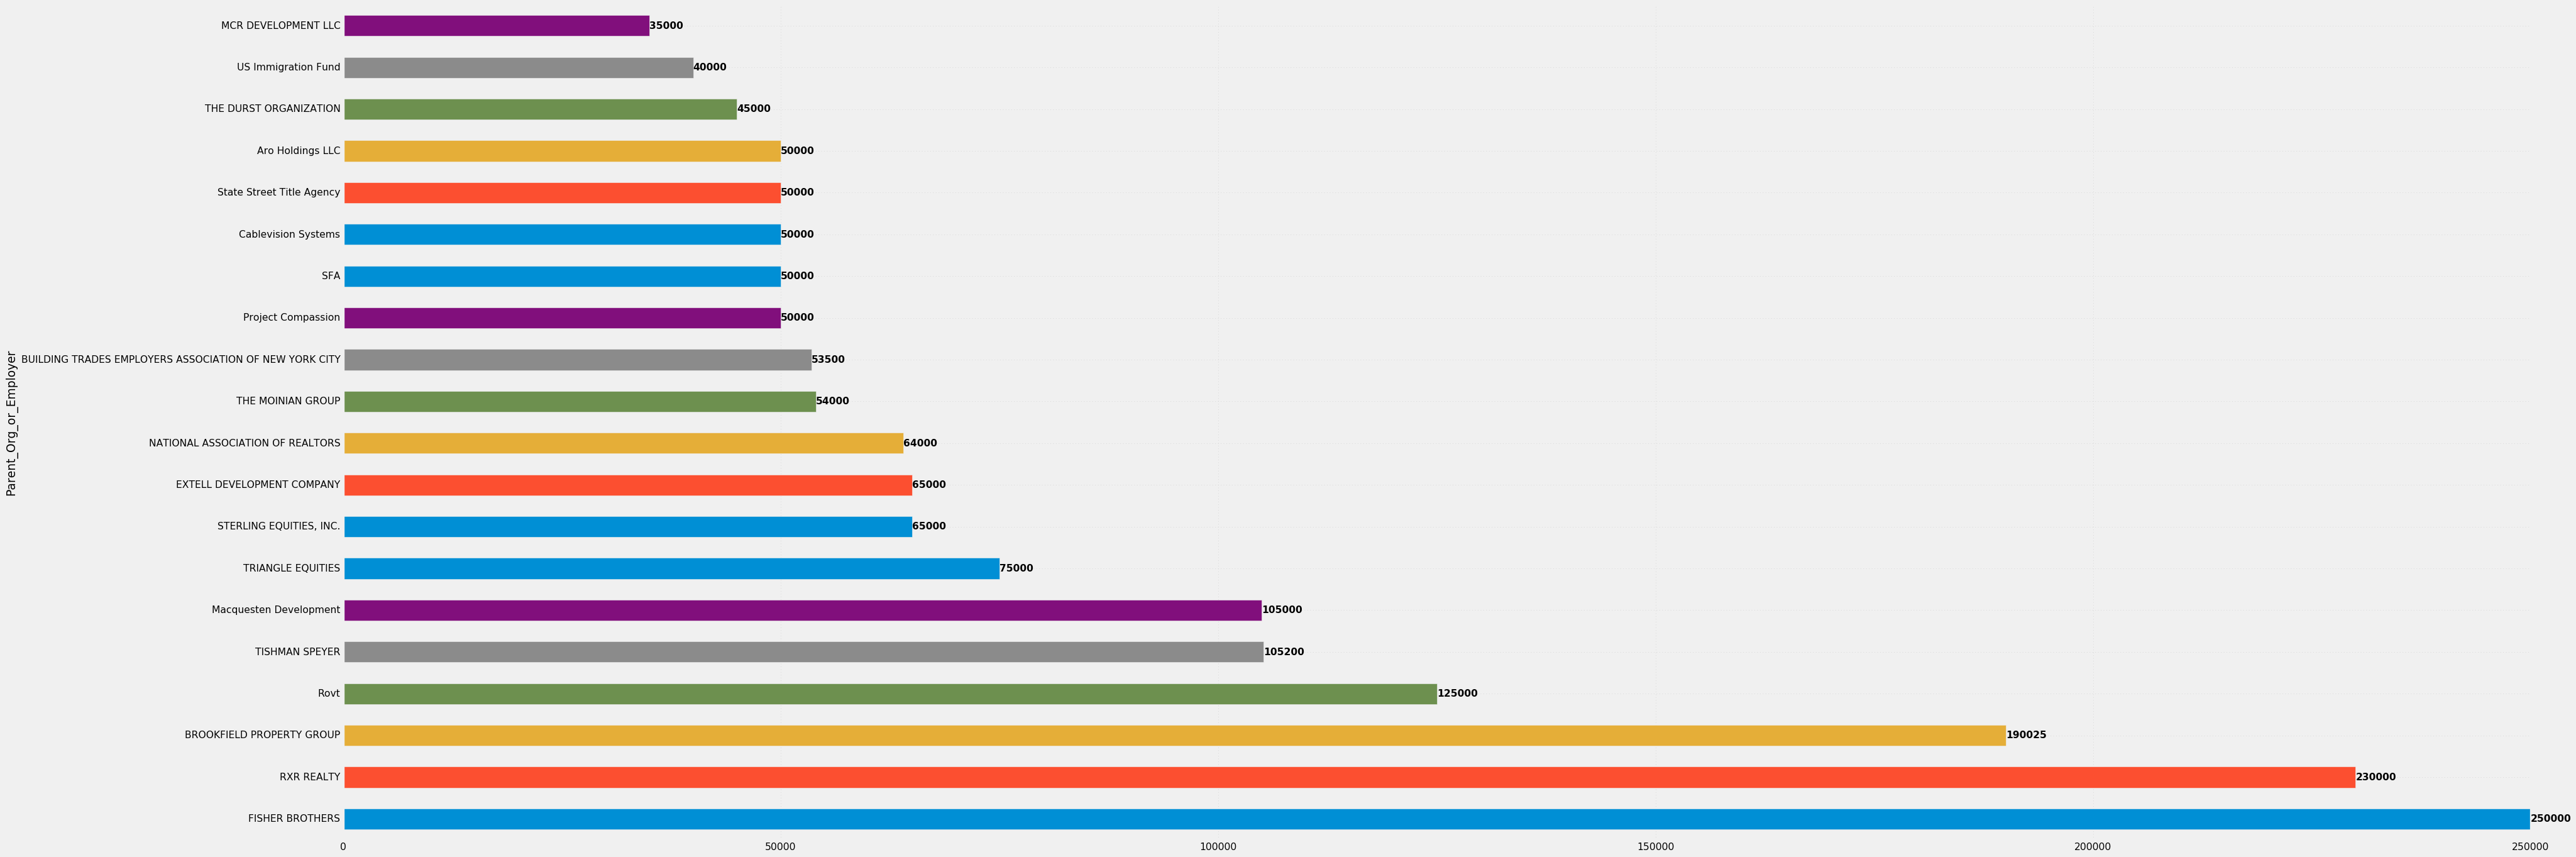

In [346]:
plt.figure(figsize=(50,20))
ax=df['2017-01-01':]\
.groupby('Parent_Org_or_Employer')['Amount_boe']\
.sum().sort_values(ascending=False).head(20)\
.plot(y='Amount_boe', x='Parent_Org_or_Employer', kind='barh')

for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')
plt.savefig('topdonors.pdf')

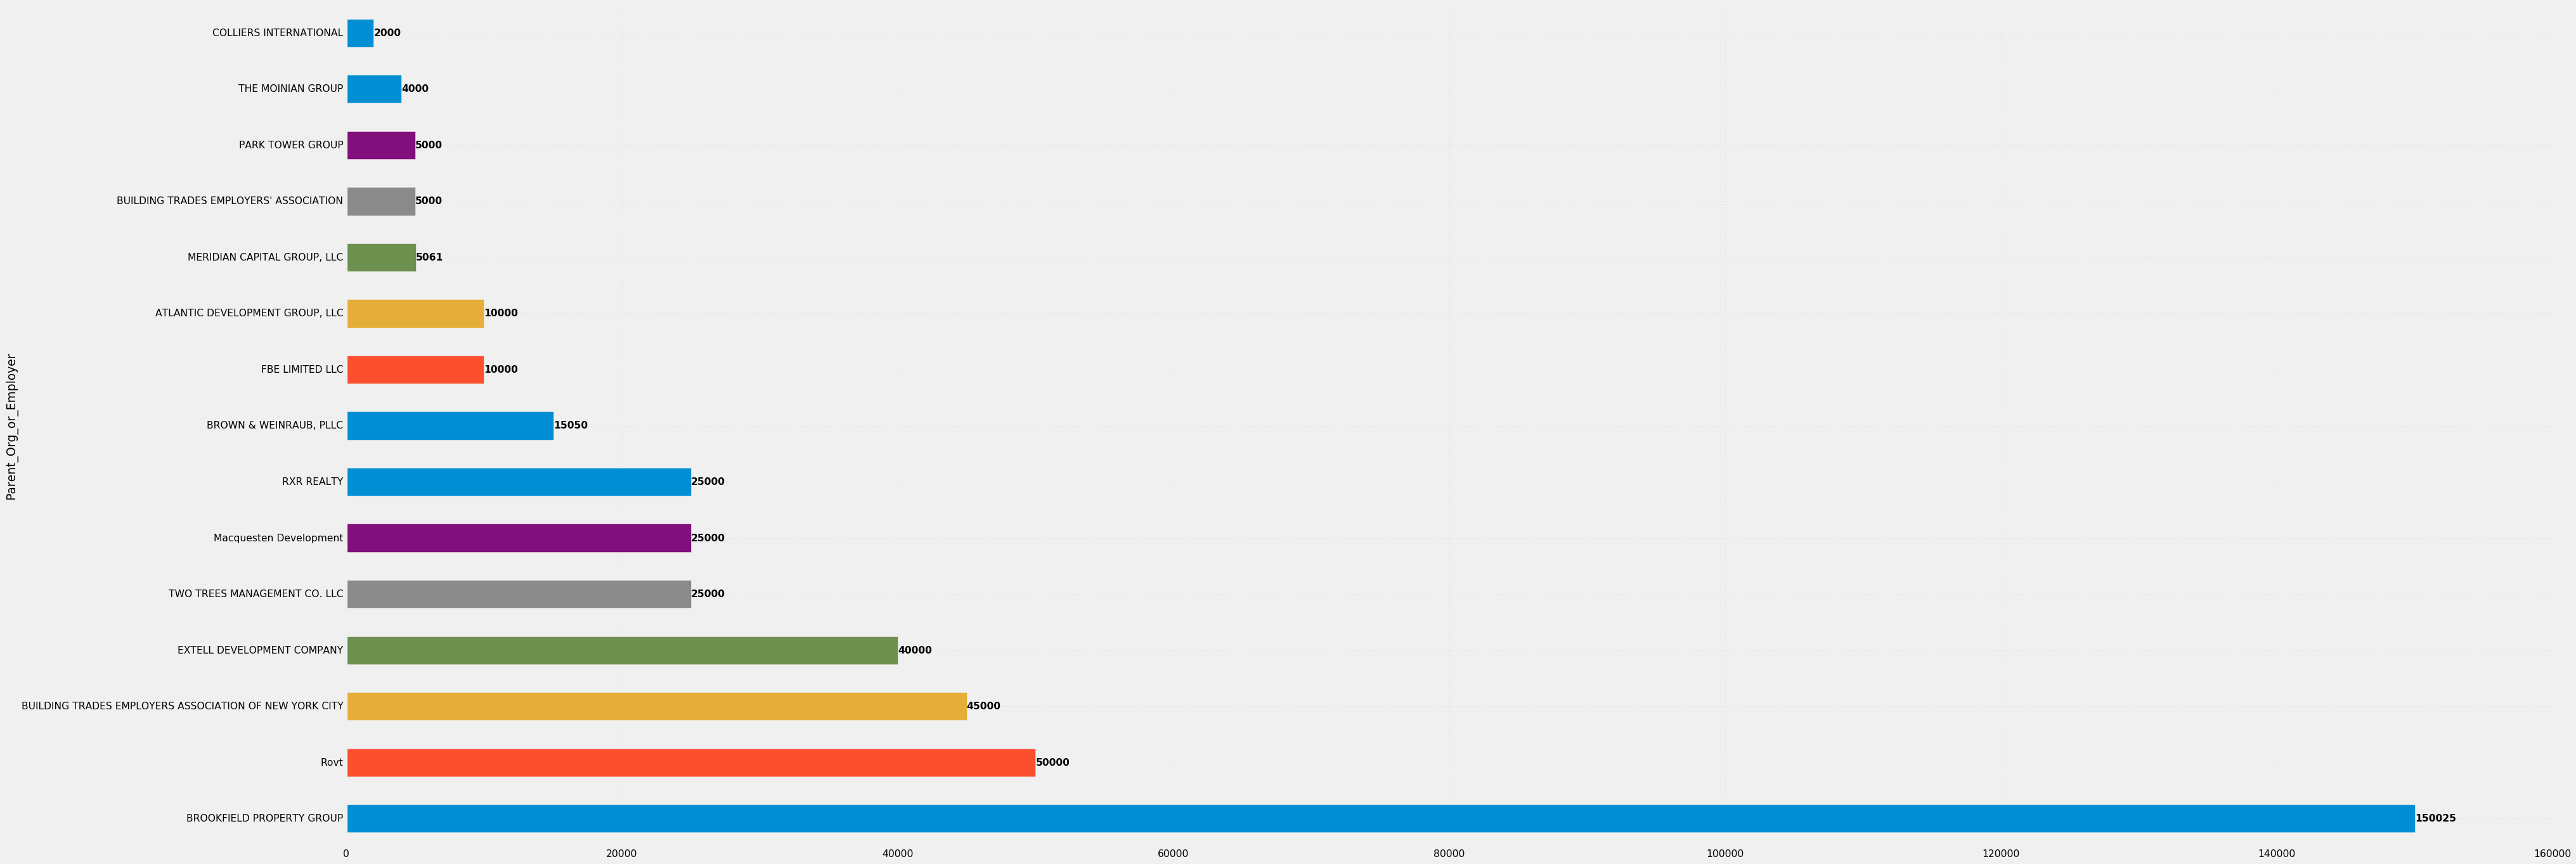

In [347]:
plt.figure(figsize=(50,20))
ax=df['2018-01-01':'2018-12-31']\
.groupby('Parent_Org_or_Employer')['Amount_boe']\
.sum().sort_values(ascending=False).head(15)\
.plot(y='Amount_boe', x='Parent_Org_or_Employer', kind='barh')

for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')
plt.savefig('topdonors.pdf')

TypeError: 'AxesSubplot' object is not iterable

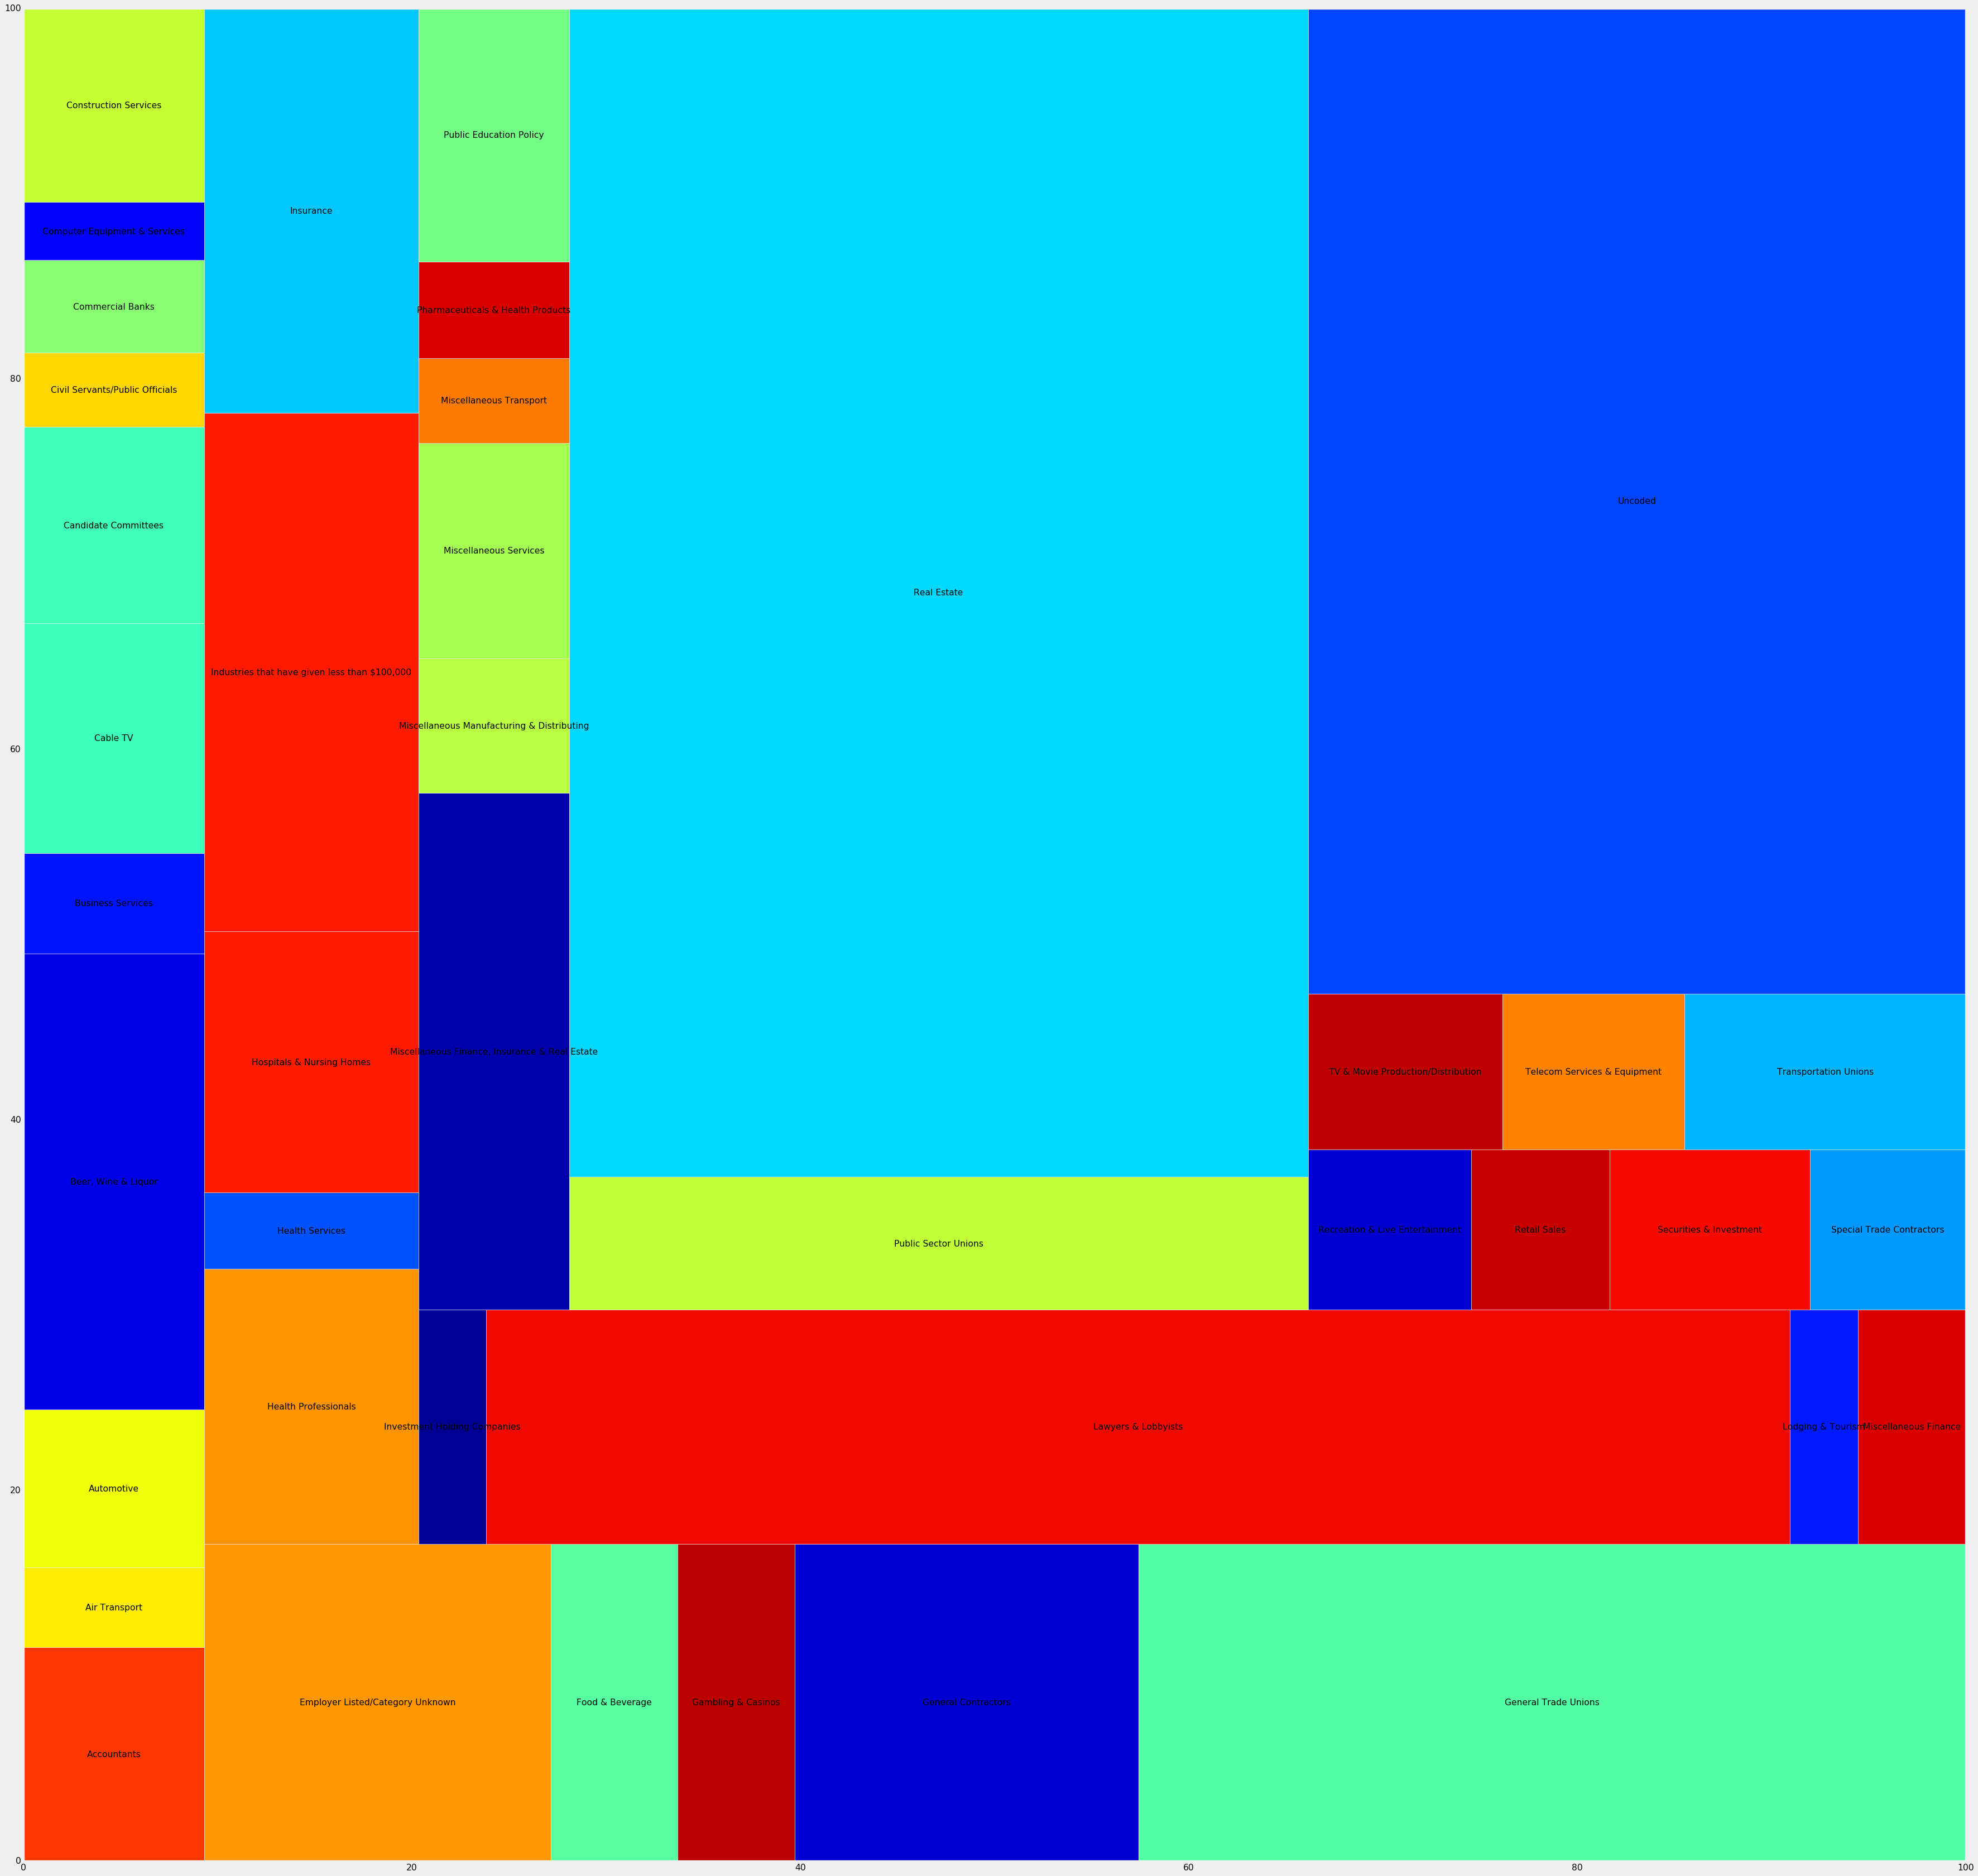

In [356]:
plt.figure(figsize=(10,10))
squares = df['2010-01-01':].groupby('General_Industry')['Amount_boe'].sum().to_frame().reset_index()
squares.loc[squares['Amount_boe']<100000, 'General_Industry']='Industries that have given less than $100,000'
squares = squares.groupby('General_Industry')['Amount_boe'].sum().to_frame().reset_index()

# If you have a data frame?
plt.figure(figsize=(50,50))
fig, ax= squarify.plot(sizes=squares['Amount_boe'], label=squares['General_Industry'] )
plt.axis('off')
plt.savefig('tree_7_22.pdf', transparent=True)
ax.legend()



In [355]:
squares

,General_Industry,Amount_boe
0,Accountants,390604.00
1,Air Transport,145700.00
2,Automotive,288700.00
3,"Beer, Wine & Liquor",832681.00
4,Business Services,183796.00
5,Cable TV,420000.00
6,Candidate Committees,359117.00
7,Civil Servants/Public Officials,135500.00
8,Commercial Banks,169100.00
9,Computer Equipment & Services,106300.00


In [352]:
rec = df['2010-01-01':]
print("In addition to the $6,205,116.61 from donor matching done with Follow the Money's historical data, I found", "${:,}".format(round(float(df[df['General_Industry']=='Real Estate']['Amount_boe'].sum())-float(6205116.61), 2))\
     ,"in Real Estate cash by matching for REBNY/RSA members, as well as LLC owner-matching from DOB records.")

In addition to the $6,205,116.61 from donor matching done with Follow the Money's historical data, I found $4,300,833.0 in Real Estate cash by matching for REBNY/RSA members, as well as LLC owner-matching from DOB records.


In [353]:
print("Cuomo has accepted",\
      "${:,}".format(df[df['General_Industry']=='Real Estate']['Amount_boe'].sum())\
     ,"from the Real Estate industry during his time in office.")

Cuomo has accepted $10,505,949.61 from the Real Estate industry during his time in office.
